# Imports

In [121]:
import numpy as np
import torch
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import mnist
import torch.nn as nn
import torch.optim as optim

# Utility Functions

In [122]:
def acc_loss_plots(history):
    # Plot the loss curves
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

    # Plot the accuracy curves
    plt.plot(history['accuracy'], label='train acc')
    plt.plot(history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

In [123]:
def visualize_predictions(predictions, x_test, y_test, class_names, num_images=10, rows=4, cols=5):
    sample_indices = np.random.choice(x_test.shape[0], num_images, replace=False)
    plt.figure(figsize=(15, 15))

    for i, idx in enumerate(sample_indices):
        plt.subplot(rows, cols, i + 1)
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        plt.imshow(x_test[idx].reshape(28, 28), cmap=plt.cm.binary)
        
        if predictions.ndim > 1: 
            predicted_label = np.argmax(predictions[idx])  
        else:
            predicted_label = predictions[idx]  

        true_label = y_test[idx]

        color = 'green' if predicted_label == true_label else 'red'
        plt.xlabel(f"{class_names[predicted_label]} (True: {class_names[true_label]})", color=color)

    plt.tight_layout()
    plt.show()


In [124]:
def plot_confusion_matrix(predictions, y_test, class_names,title, color="Blues"):
    if predictions.ndim == 1:
        pred_classes = predictions
    else:
        # convert predicted probabilities to class indices
        pred_classes = np.argmax(predictions, axis=1)

    # calculate the confusion matrix
    cm = confusion_matrix(y_test, pred_classes)

    # plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=color,
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted', color='purple')
    plt.ylabel('True', color='green')
    plt.title(title, color='blue')
    plt.show()


# Data Preparation
- **Normalization**: Preprocessed the data by normalizing pixel values to the range [0, 1].  
- **Flattening**: Converted 28x28 images into 1D vectors of size 784.  
- **Dataset Split**: Divided the dataset into:
  - **60% Training**  
  - **20% Validation**  
  - **20% Testing**

In [125]:
# 1. Load MNIST dataset from keras
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# 2. Preprocess data
x_train_full = x_train_full.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0

# Flatten images to 1D vectors
x_train_full = x_train_full.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Split the data
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                               torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                              torch.tensor(y_test, dtype=torch.long))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Softmax Regression
- Built a Softmax Regression model using PyTorch with the following specifications:  
  - **Input Size**: 784 (flattened image size).  
  - **Output Classes**: 10 (digits 0-9).  

In [127]:
# Define the Softmax Regression Model
class SoftmaxRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)
# Model setup
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

# Training the model
def train_model(optimizer, model, train_loader, val_loader, epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer,  model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}

Epoch 1/50, Train Loss: 1.0694, Train Accuracy: 78.44%, Val Loss: 0.6825, Val Accuracy: 84.71%
Epoch 2/50, Train Loss: 0.5946, Train Accuracy: 86.12%, Val Loss: 0.5348, Val Accuracy: 86.94%
Epoch 3/50, Train Loss: 0.5024, Train Accuracy: 87.44%, Val Loss: 0.4748, Val Accuracy: 87.74%
Epoch 4/50, Train Loss: 0.4579, Train Accuracy: 88.18%, Val Loss: 0.4408, Val Accuracy: 88.36%
Epoch 5/50, Train Loss: 0.4305, Train Accuracy: 88.73%, Val Loss: 0.4183, Val Accuracy: 88.78%
Epoch 6/50, Train Loss: 0.4114, Train Accuracy: 89.07%, Val Loss: 0.4014, Val Accuracy: 89.22%
Epoch 7/50, Train Loss: 0.3971, Train Accuracy: 89.35%, Val Loss: 0.3896, Val Accuracy: 89.41%
Epoch 8/50, Train Loss: 0.3860, Train Accuracy: 89.60%, Val Loss: 0.3790, Val Accuracy: 89.79%
Epoch 9/50, Train Loss: 0.3768, Train Accuracy: 89.76%, Val Loss: 0.3710, Val Accuracy: 89.91%
Epoch 10/50, Train Loss: 0.3691, Train Accuracy: 89.90%, Val Loss: 0.3642, Val Accuracy: 90.13%
Epoch 11/50, Train Loss: 0.3627, Train Accuracy: 

# Visualizations

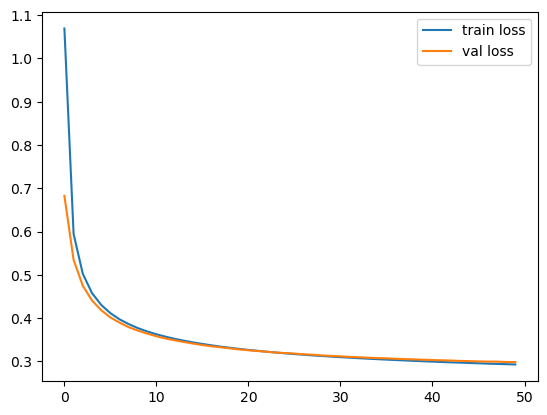

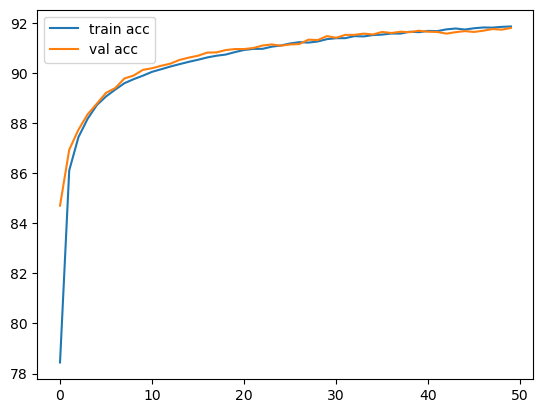

In [128]:
acc_loss_plots(history)

# Analysis

### Evaluation

In [129]:
def evaluate_model():
    test_loss = 0
    correct = 0
    model.eval()

    test_pred = []  # To store predictions
    true_labels = []  # To store true labels
    x_test = []  # To store test images for visualization

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch.float())
            test_loss += criterion(outputs, y_batch).item()

            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()

            # Store batch-wise data for visualization
            test_pred.extend(preds.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
            x_test.extend(X_batch.cpu().numpy())

    # Compute Test Accuracy
    test_accuracy = correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Convert lists to numpy arrays
    test_pred = np.array(test_pred)
    y_test = np.array(true_labels)
    x_test = np.array(x_test)
    return test_pred, x_test, y_test

Test Loss: 0.2870, Test Accuracy: 0.9197


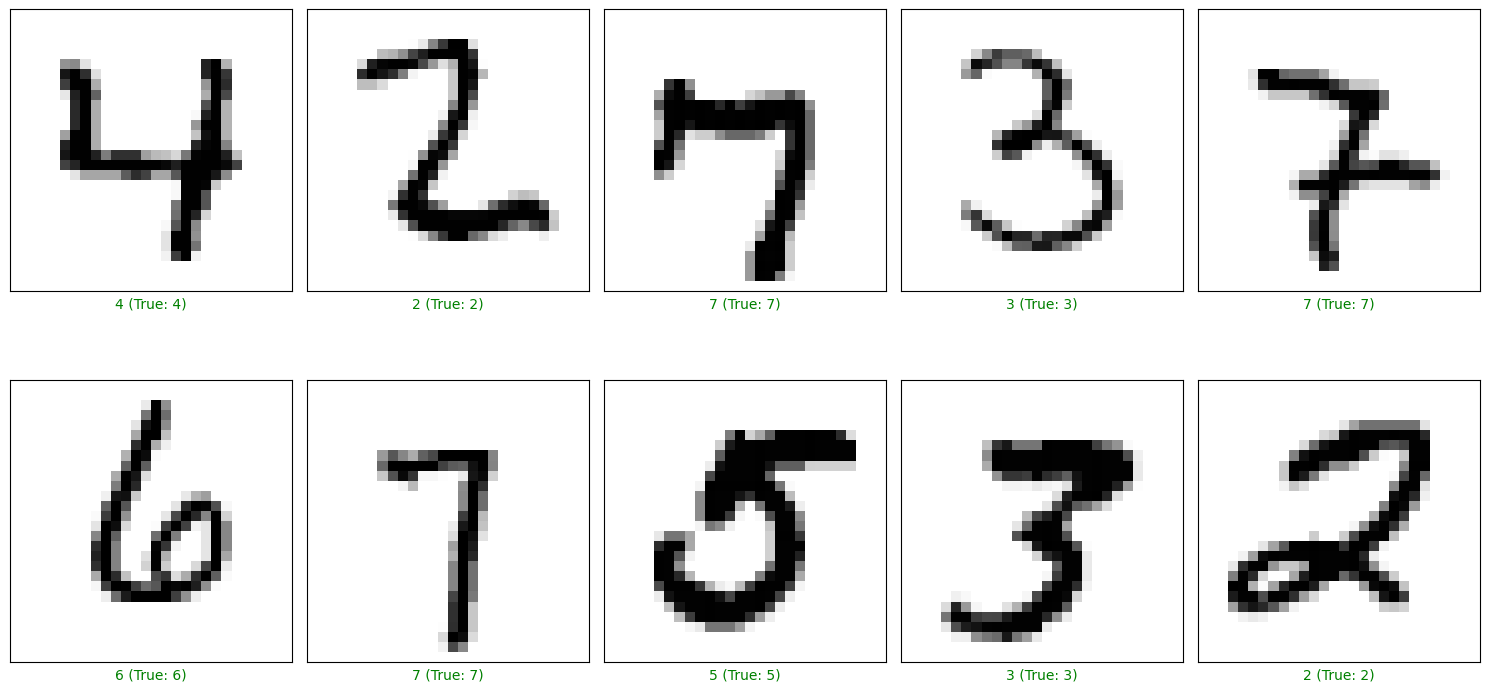

In [130]:
test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

Test Loss: 0.2870, Test Accuracy: 0.9197


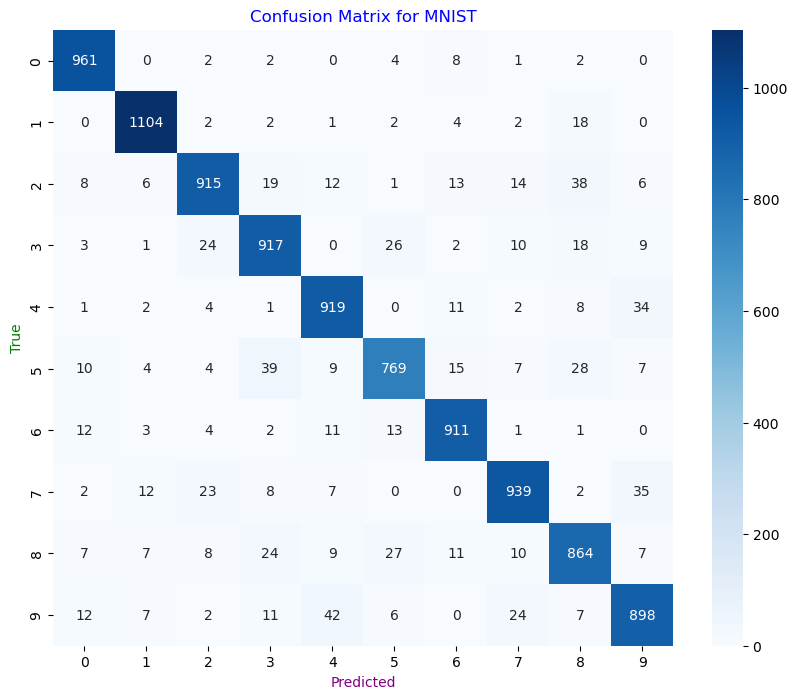

In [131]:
test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")

# Analysis of Model Hyperparameters and Their Impact on Performance

## 1. Changing Learning Rates
### Experiment
- Evaluate the model's performance using at least **4 different learning rates**.
- Common values to test:
  - **0.1**: High learning rate, may lead to unstable training.
  - **0.05**: Slightly lower but still aggressive learning rate.
  - **0.01**: Default learning rate.
  - **0.001**: Smaller learning rate, useful for fine-tuning.
  - **0.0001**: Very small learning rate, may result in slower convergence.

### Expected Observations
- **High Learning Rate**: Model might diverge or oscillate without converging to a minimum.
- **Optimal Learning Rate**: Model converges efficiently with good performance on both training and validation datasets.
- **Low Learning Rate**: Training takes longer and might get stuck in local minima.

---


Epoch 1/50, Train Loss: 0.2949, Train Accuracy: 91.74%, Val Loss: 0.2968, Val Accuracy: 91.77%
Epoch 2/50, Train Loss: 0.2902, Train Accuracy: 91.87%, Val Loss: 0.2933, Val Accuracy: 91.85%
Epoch 3/50, Train Loss: 0.2856, Train Accuracy: 92.13%, Val Loss: 0.2923, Val Accuracy: 91.91%
Epoch 4/50, Train Loss: 0.2823, Train Accuracy: 92.16%, Val Loss: 0.2882, Val Accuracy: 92.14%
Epoch 5/50, Train Loss: 0.2797, Train Accuracy: 92.28%, Val Loss: 0.2882, Val Accuracy: 92.08%
Epoch 6/50, Train Loss: 0.2769, Train Accuracy: 92.32%, Val Loss: 0.2865, Val Accuracy: 92.05%
Epoch 7/50, Train Loss: 0.2752, Train Accuracy: 92.39%, Val Loss: 0.2853, Val Accuracy: 92.05%
Epoch 8/50, Train Loss: 0.2733, Train Accuracy: 92.38%, Val Loss: 0.2839, Val Accuracy: 92.15%
Epoch 9/50, Train Loss: 0.2714, Train Accuracy: 92.49%, Val Loss: 0.2836, Val Accuracy: 92.14%
Epoch 10/50, Train Loss: 0.2700, Train Accuracy: 92.52%, Val Loss: 0.2818, Val Accuracy: 92.08%
Epoch 11/50, Train Loss: 0.2685, Train Accuracy: 

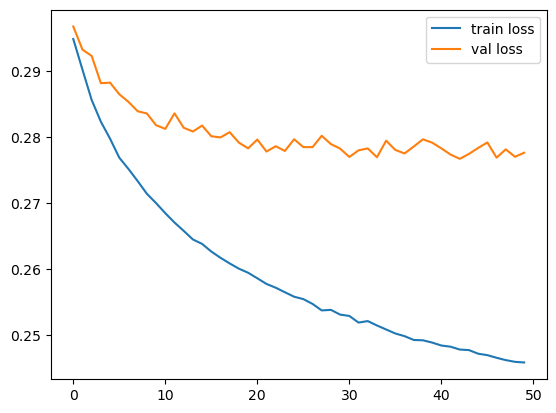

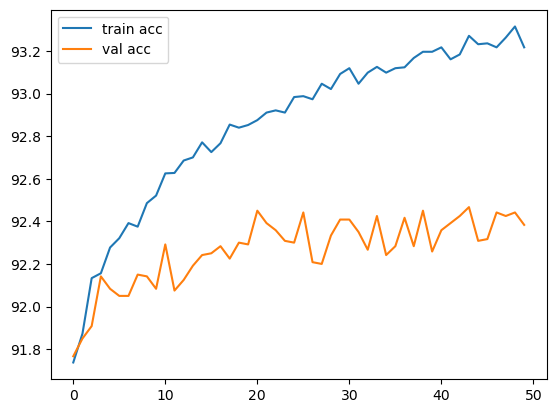

Test Loss: 0.2674, Test Accuracy: 0.9263


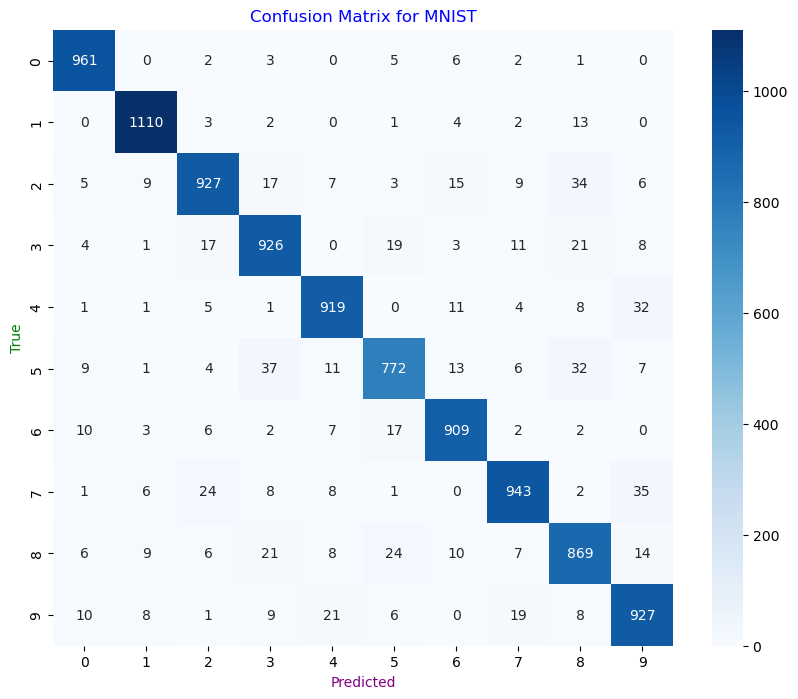

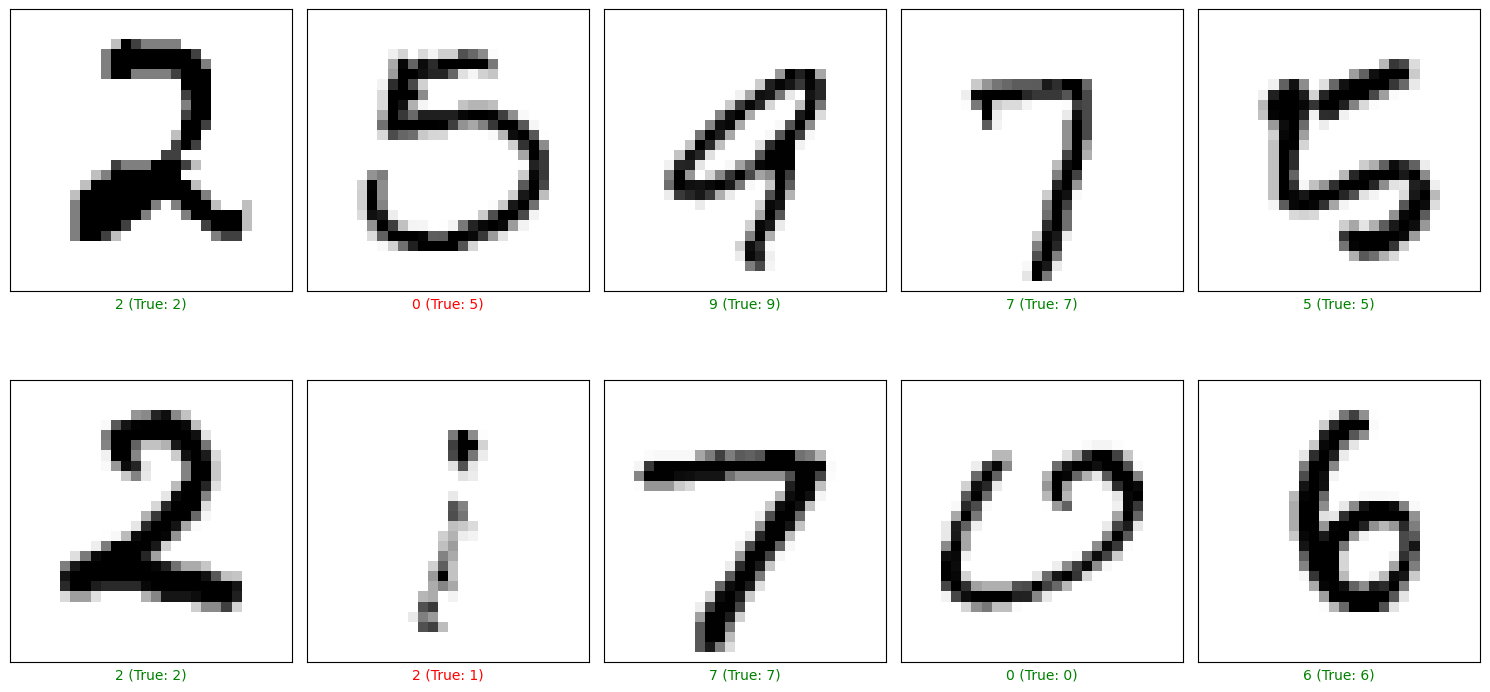

In [132]:
# 0.1 learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

Epoch 1/100, Train Loss: 0.2605, Train Accuracy: 92.86%, Val Loss: 0.2788, Val Accuracy: 92.38%
Epoch 2/100, Train Loss: 0.2601, Train Accuracy: 92.83%, Val Loss: 0.2788, Val Accuracy: 92.37%
Epoch 3/100, Train Loss: 0.2594, Train Accuracy: 92.86%, Val Loss: 0.2791, Val Accuracy: 92.38%
Epoch 4/100, Train Loss: 0.2591, Train Accuracy: 92.86%, Val Loss: 0.2792, Val Accuracy: 92.19%
Epoch 5/100, Train Loss: 0.2584, Train Accuracy: 92.88%, Val Loss: 0.2798, Val Accuracy: 92.32%
Epoch 6/100, Train Loss: 0.2581, Train Accuracy: 92.93%, Val Loss: 0.2778, Val Accuracy: 92.39%
Epoch 7/100, Train Loss: 0.2579, Train Accuracy: 92.89%, Val Loss: 0.2778, Val Accuracy: 92.42%
Epoch 8/100, Train Loss: 0.2574, Train Accuracy: 92.92%, Val Loss: 0.2797, Val Accuracy: 92.22%
Epoch 9/100, Train Loss: 0.2573, Train Accuracy: 92.94%, Val Loss: 0.2781, Val Accuracy: 92.38%
Epoch 10/100, Train Loss: 0.2567, Train Accuracy: 92.90%, Val Loss: 0.2784, Val Accuracy: 92.39%
Epoch 11/100, Train Loss: 0.2564, Train

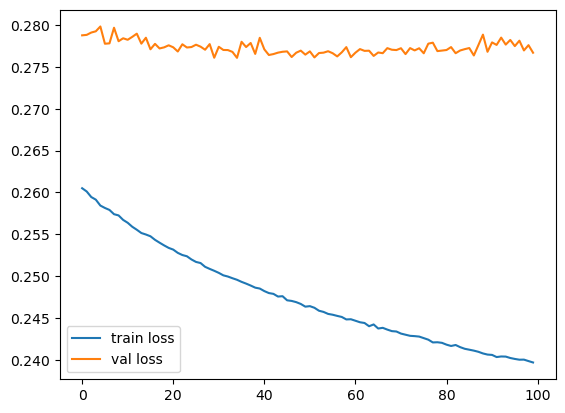

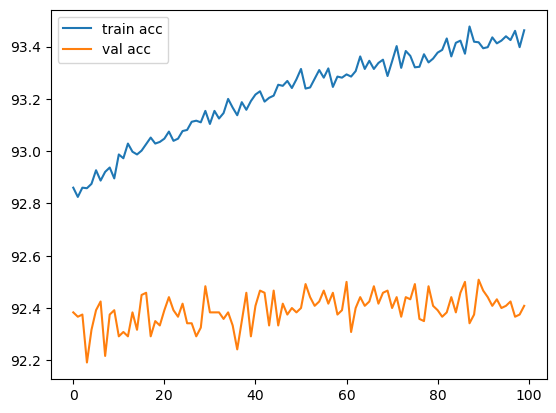

Test Loss: 0.2671, Test Accuracy: 0.9267


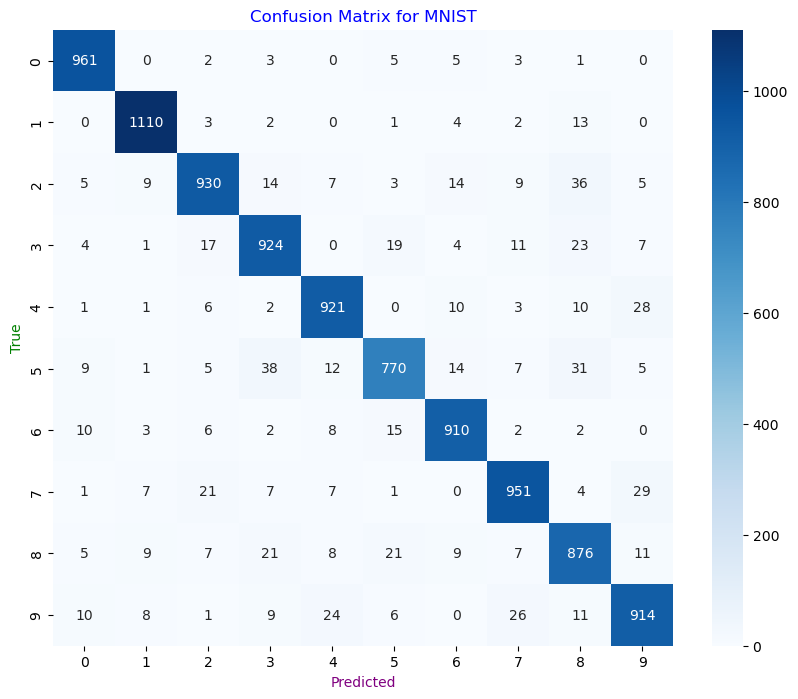

Test Loss: 0.2671, Test Accuracy: 0.9267


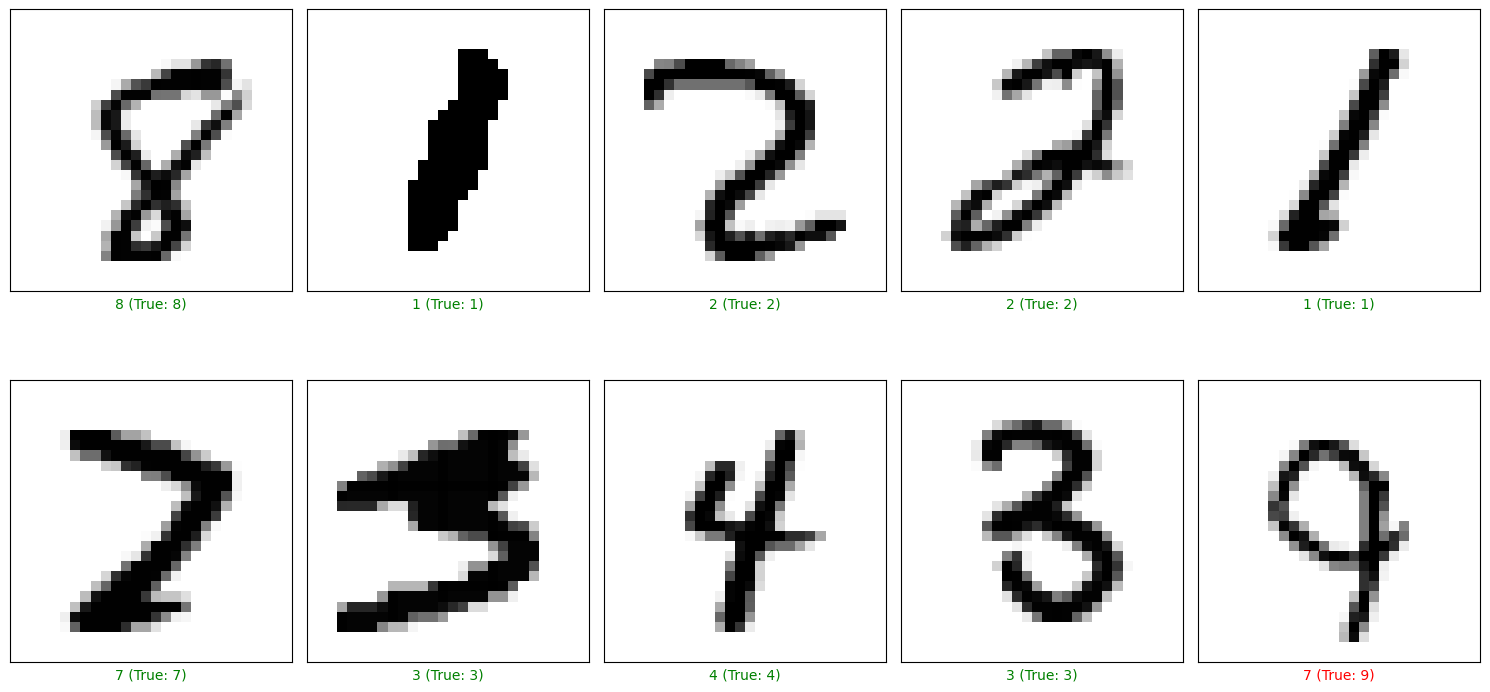

In [97]:
# 0.05 learning rate
optimizer = optim.SGD(model.parameters(), lr=0.05) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

Epoch 1/100, Train Loss: 0.2374, Train Accuracy: 93.54%, Val Loss: 0.2764, Val Accuracy: 92.43%
Epoch 2/100, Train Loss: 0.2372, Train Accuracy: 93.53%, Val Loss: 0.2764, Val Accuracy: 92.41%
Epoch 3/100, Train Loss: 0.2372, Train Accuracy: 93.52%, Val Loss: 0.2764, Val Accuracy: 92.42%
Epoch 4/100, Train Loss: 0.2372, Train Accuracy: 93.52%, Val Loss: 0.2764, Val Accuracy: 92.46%
Epoch 5/100, Train Loss: 0.2372, Train Accuracy: 93.54%, Val Loss: 0.2764, Val Accuracy: 92.45%
Epoch 6/100, Train Loss: 0.2372, Train Accuracy: 93.53%, Val Loss: 0.2764, Val Accuracy: 92.47%
Epoch 7/100, Train Loss: 0.2371, Train Accuracy: 93.52%, Val Loss: 0.2765, Val Accuracy: 92.45%
Epoch 8/100, Train Loss: 0.2371, Train Accuracy: 93.52%, Val Loss: 0.2765, Val Accuracy: 92.44%
Epoch 9/100, Train Loss: 0.2371, Train Accuracy: 93.54%, Val Loss: 0.2765, Val Accuracy: 92.43%
Epoch 10/100, Train Loss: 0.2371, Train Accuracy: 93.51%, Val Loss: 0.2765, Val Accuracy: 92.43%
Epoch 11/100, Train Loss: 0.2371, Train

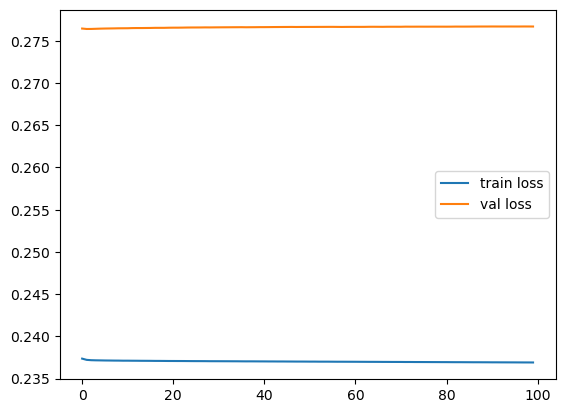

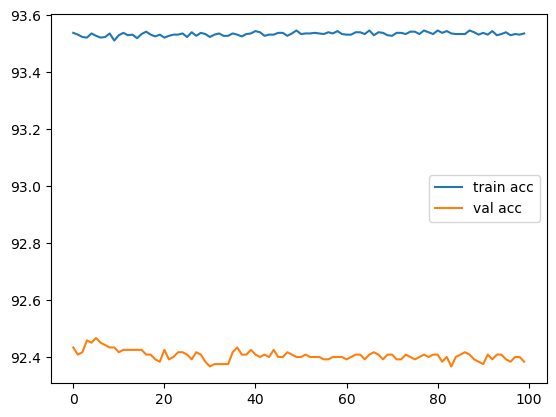

Test Loss: 0.2668, Test Accuracy: 0.9259


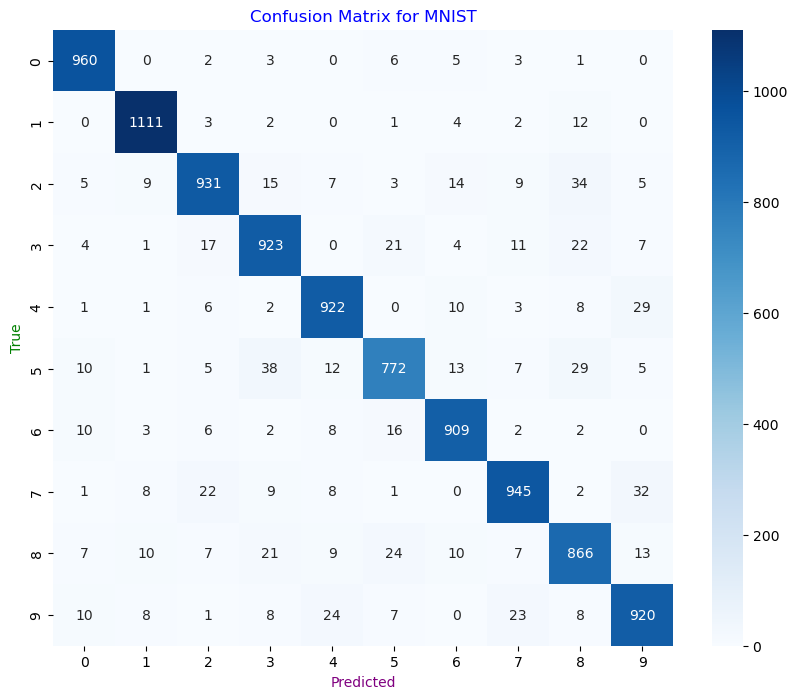

Test Loss: 0.2668, Test Accuracy: 0.9259


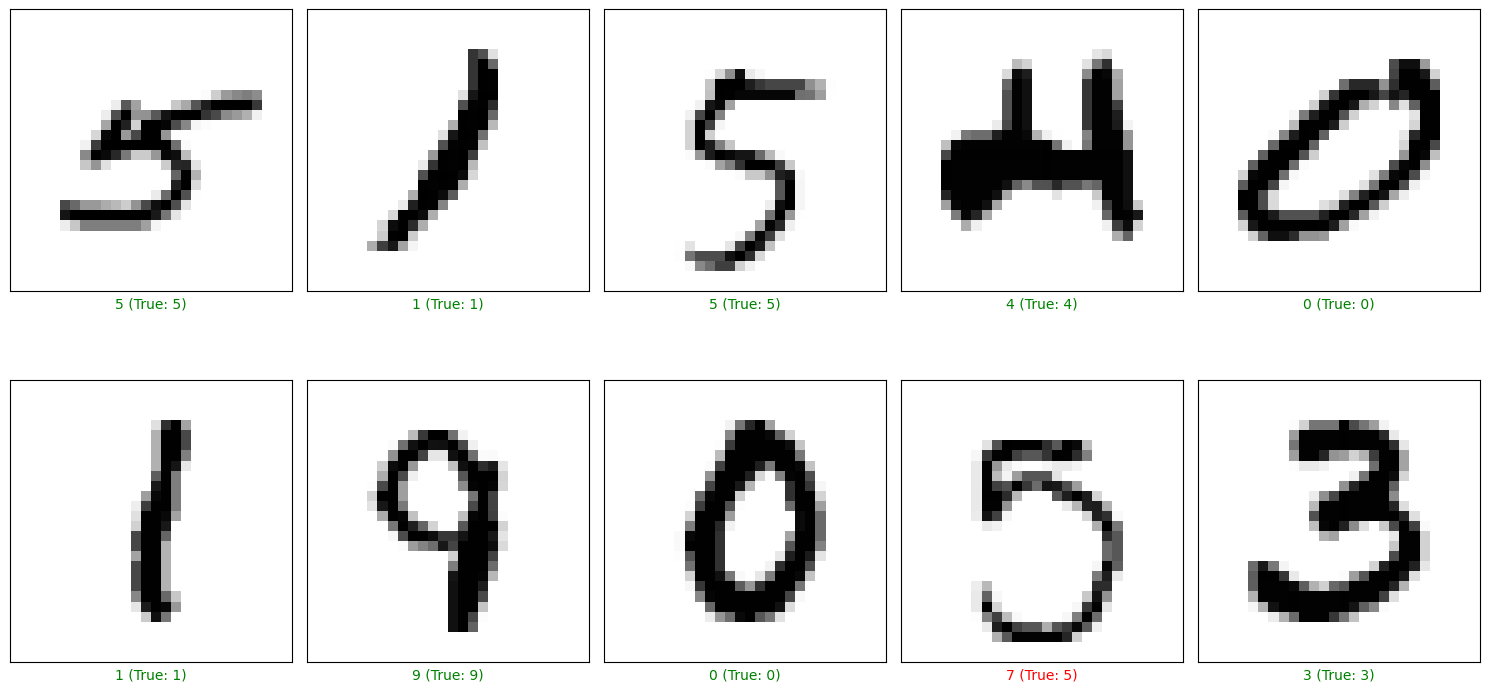

In [98]:
# 0.001 learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

Epoch 1/100, Train Loss: 0.2369, Train Accuracy: 93.53%, Val Loss: 0.2767, Val Accuracy: 92.38%
Epoch 2/100, Train Loss: 0.2369, Train Accuracy: 93.54%, Val Loss: 0.2767, Val Accuracy: 92.38%
Epoch 3/100, Train Loss: 0.2369, Train Accuracy: 93.54%, Val Loss: 0.2767, Val Accuracy: 92.38%
Epoch 4/100, Train Loss: 0.2369, Train Accuracy: 93.53%, Val Loss: 0.2767, Val Accuracy: 92.38%
Epoch 5/100, Train Loss: 0.2369, Train Accuracy: 93.53%, Val Loss: 0.2767, Val Accuracy: 92.38%
Epoch 6/100, Train Loss: 0.2369, Train Accuracy: 93.53%, Val Loss: 0.2767, Val Accuracy: 92.38%
Epoch 7/100, Train Loss: 0.2369, Train Accuracy: 93.53%, Val Loss: 0.2767, Val Accuracy: 92.38%
Epoch 8/100, Train Loss: 0.2369, Train Accuracy: 93.53%, Val Loss: 0.2767, Val Accuracy: 92.39%
Epoch 9/100, Train Loss: 0.2369, Train Accuracy: 93.54%, Val Loss: 0.2767, Val Accuracy: 92.39%
Epoch 10/100, Train Loss: 0.2369, Train Accuracy: 93.54%, Val Loss: 0.2767, Val Accuracy: 92.39%
Epoch 11/100, Train Loss: 0.2369, Train

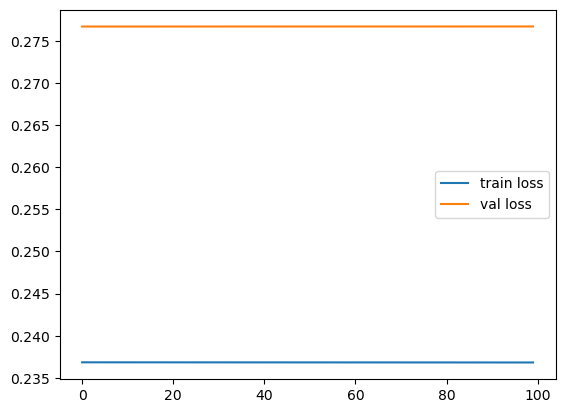

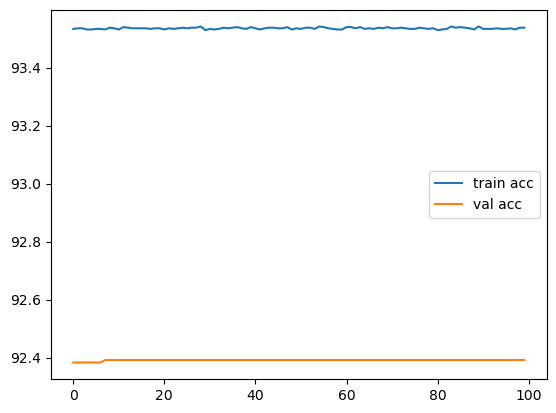

Test Loss: 0.2668, Test Accuracy: 0.9259


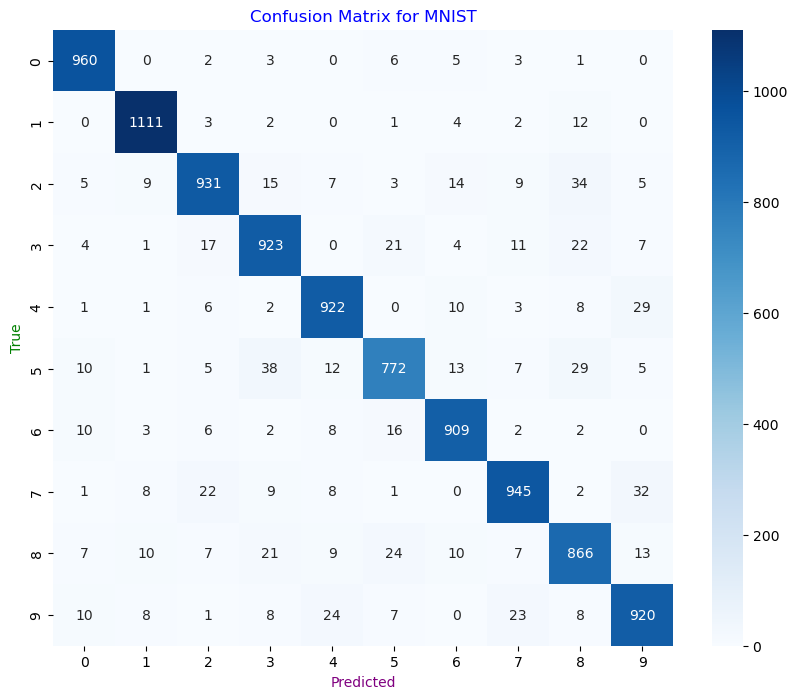

Test Loss: 0.2668, Test Accuracy: 0.9259


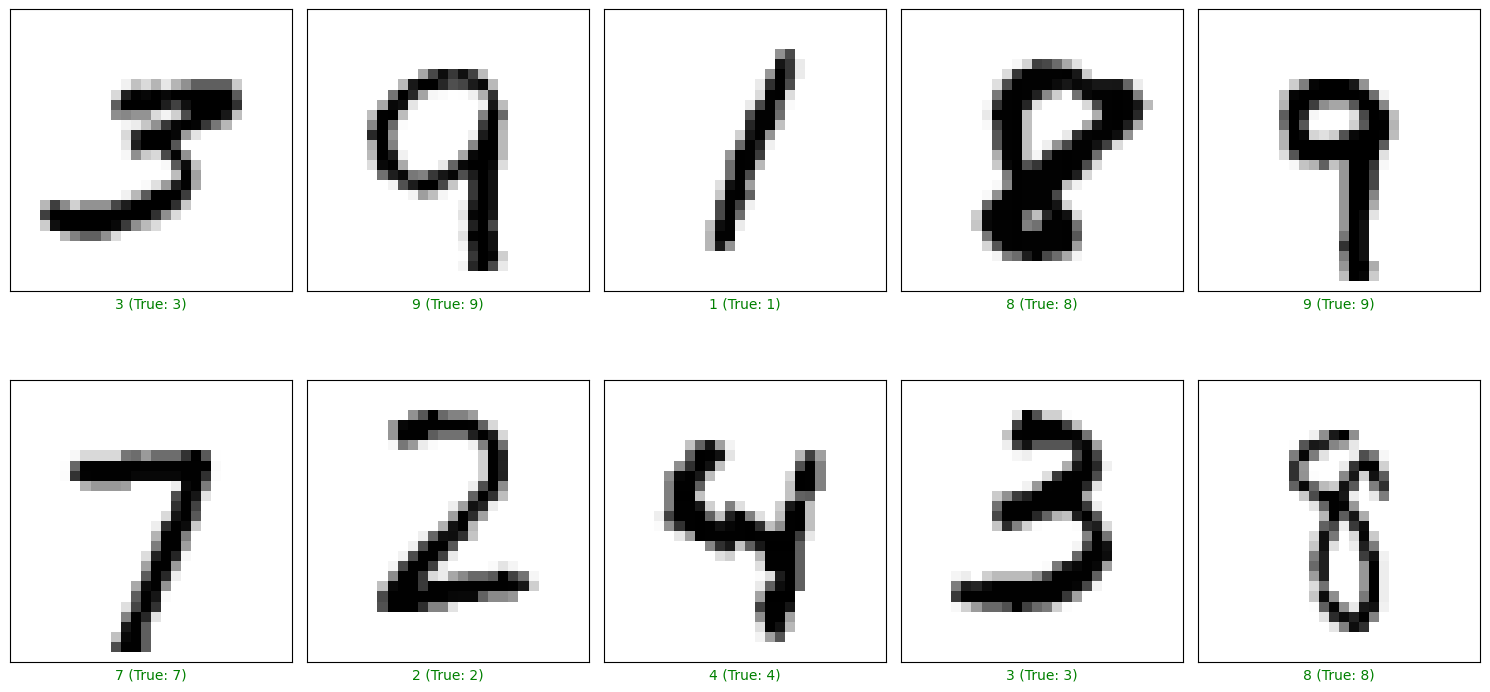

In [99]:
# 0.0001 learning rate
optimizer = optim.SGD(model.parameters(), lr=0.0001) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

## 2. Changing Batch Sizes
### Experiment
- Evaluate the model's performance using at least **4 different batch sizes**.
- Common values to test:
  - **16**: Small batch size, leads to more updates but can be noisy.
  - **32**: Moderate batch size, balances updates and noise.
  - **64**: Default batch size.
  - **128**: Large batch size, fewer updates per epoch but smoother gradients.
  - **256**: Very large batch size, further reduces gradient noise but may require more epochs.

### Expected Observations
- **Small Batch Size**: Can lead to faster convergence but higher variance in the loss curve.
- **Large Batch Size**: Produces smoother gradients but might require more epochs to converge.

---

Epoch 1/100, Train Loss: 0.2388, Train Accuracy: 93.48%, Val Loss: 0.2792, Val Accuracy: 92.38%
Epoch 2/100, Train Loss: 0.2389, Train Accuracy: 93.45%, Val Loss: 0.2777, Val Accuracy: 92.38%
Epoch 3/100, Train Loss: 0.2386, Train Accuracy: 93.46%, Val Loss: 0.2771, Val Accuracy: 92.38%
Epoch 4/100, Train Loss: 0.2386, Train Accuracy: 93.47%, Val Loss: 0.2779, Val Accuracy: 92.36%
Epoch 5/100, Train Loss: 0.2384, Train Accuracy: 93.47%, Val Loss: 0.2788, Val Accuracy: 92.33%
Epoch 6/100, Train Loss: 0.2385, Train Accuracy: 93.51%, Val Loss: 0.2777, Val Accuracy: 92.44%
Epoch 7/100, Train Loss: 0.2382, Train Accuracy: 93.49%, Val Loss: 0.2790, Val Accuracy: 92.33%
Epoch 8/100, Train Loss: 0.2383, Train Accuracy: 93.50%, Val Loss: 0.2793, Val Accuracy: 92.28%
Epoch 9/100, Train Loss: 0.2382, Train Accuracy: 93.46%, Val Loss: 0.2774, Val Accuracy: 92.36%
Epoch 10/100, Train Loss: 0.2382, Train Accuracy: 93.51%, Val Loss: 0.2787, Val Accuracy: 92.41%
Epoch 11/100, Train Loss: 0.2380, Train

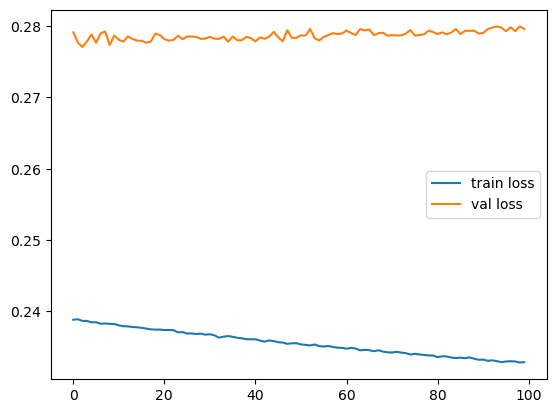

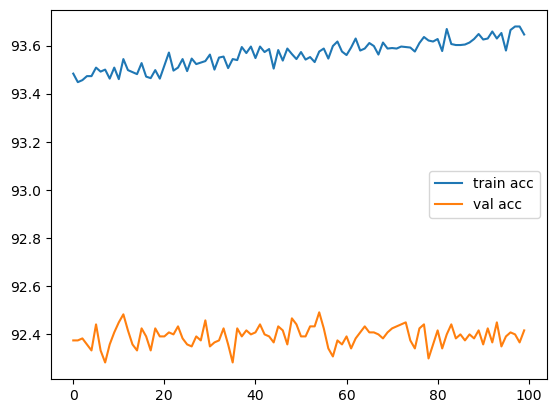

Test Loss: 0.2688, Test Accuracy: 0.9260


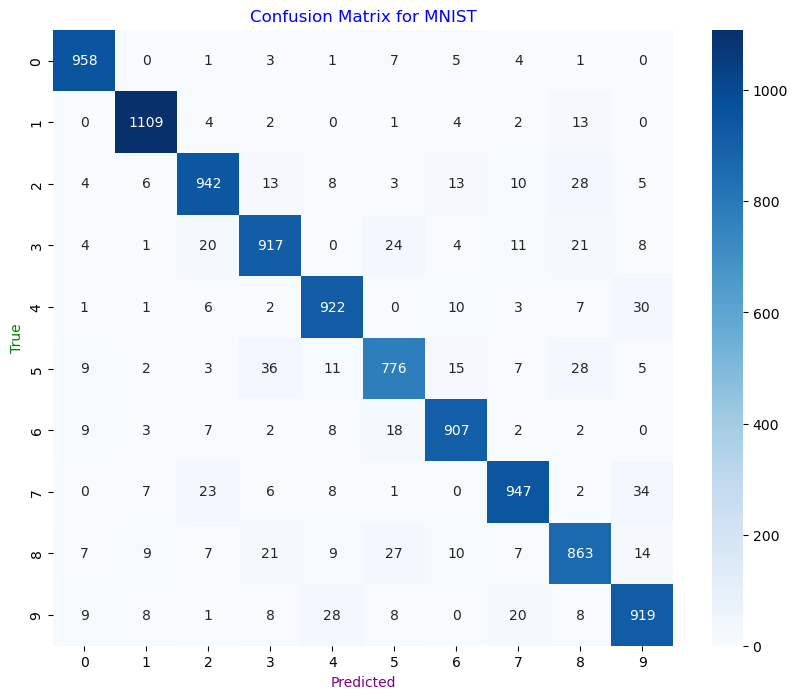

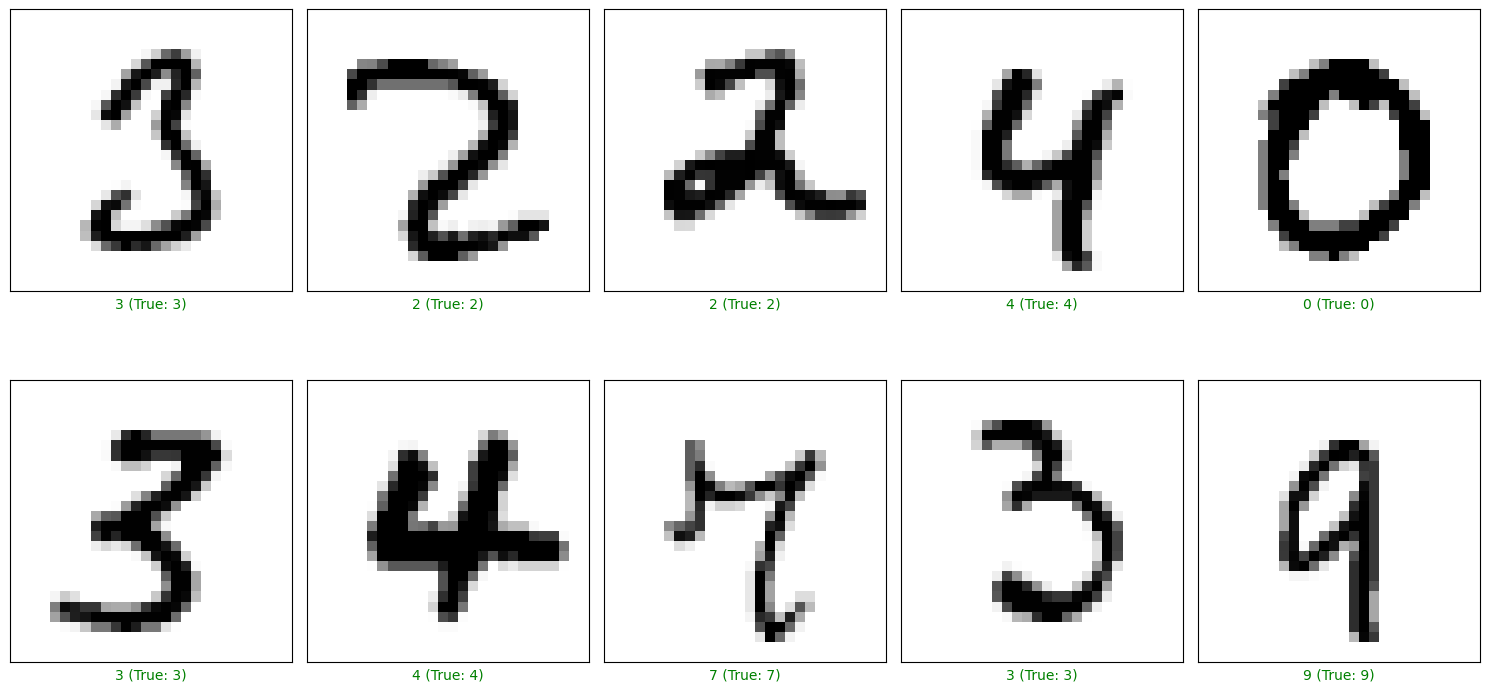

In [100]:
# 16 batch_size
batch_size = 16
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

Epoch 1/50, Train Loss: 0.2418, Train Accuracy: 93.42%, Val Loss: 0.2775, Val Accuracy: 92.52%
Epoch 2/50, Train Loss: 0.2416, Train Accuracy: 93.38%, Val Loss: 0.2772, Val Accuracy: 92.44%
Epoch 3/50, Train Loss: 0.2416, Train Accuracy: 93.42%, Val Loss: 0.2774, Val Accuracy: 92.49%
Epoch 4/50, Train Loss: 0.2414, Train Accuracy: 93.41%, Val Loss: 0.2771, Val Accuracy: 92.52%
Epoch 5/50, Train Loss: 0.2415, Train Accuracy: 93.39%, Val Loss: 0.2772, Val Accuracy: 92.43%
Epoch 6/50, Train Loss: 0.2413, Train Accuracy: 93.45%, Val Loss: 0.2771, Val Accuracy: 92.47%
Epoch 7/50, Train Loss: 0.2412, Train Accuracy: 93.45%, Val Loss: 0.2773, Val Accuracy: 92.52%
Epoch 8/50, Train Loss: 0.2413, Train Accuracy: 93.43%, Val Loss: 0.2770, Val Accuracy: 92.47%
Epoch 9/50, Train Loss: 0.2412, Train Accuracy: 93.40%, Val Loss: 0.2774, Val Accuracy: 92.48%
Epoch 10/50, Train Loss: 0.2412, Train Accuracy: 93.40%, Val Loss: 0.2772, Val Accuracy: 92.42%
Epoch 11/50, Train Loss: 0.2411, Train Accuracy: 

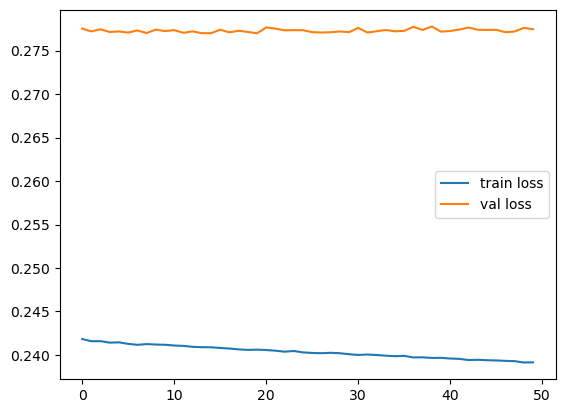

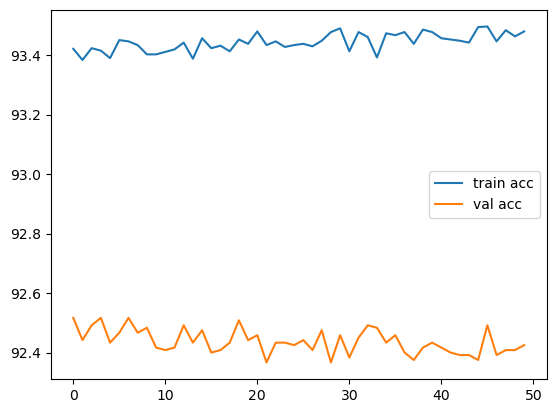

Test Loss: 0.2673, Test Accuracy: 0.9255


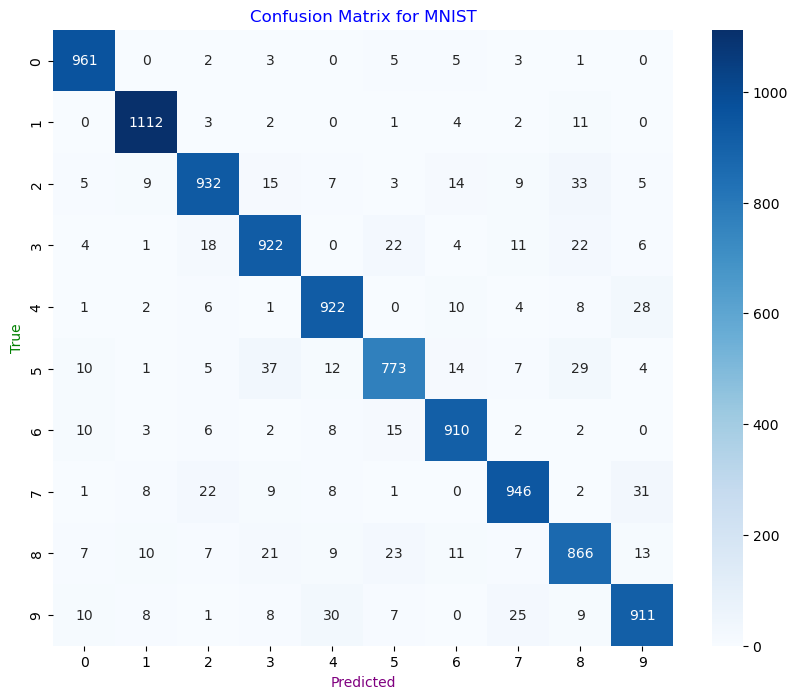

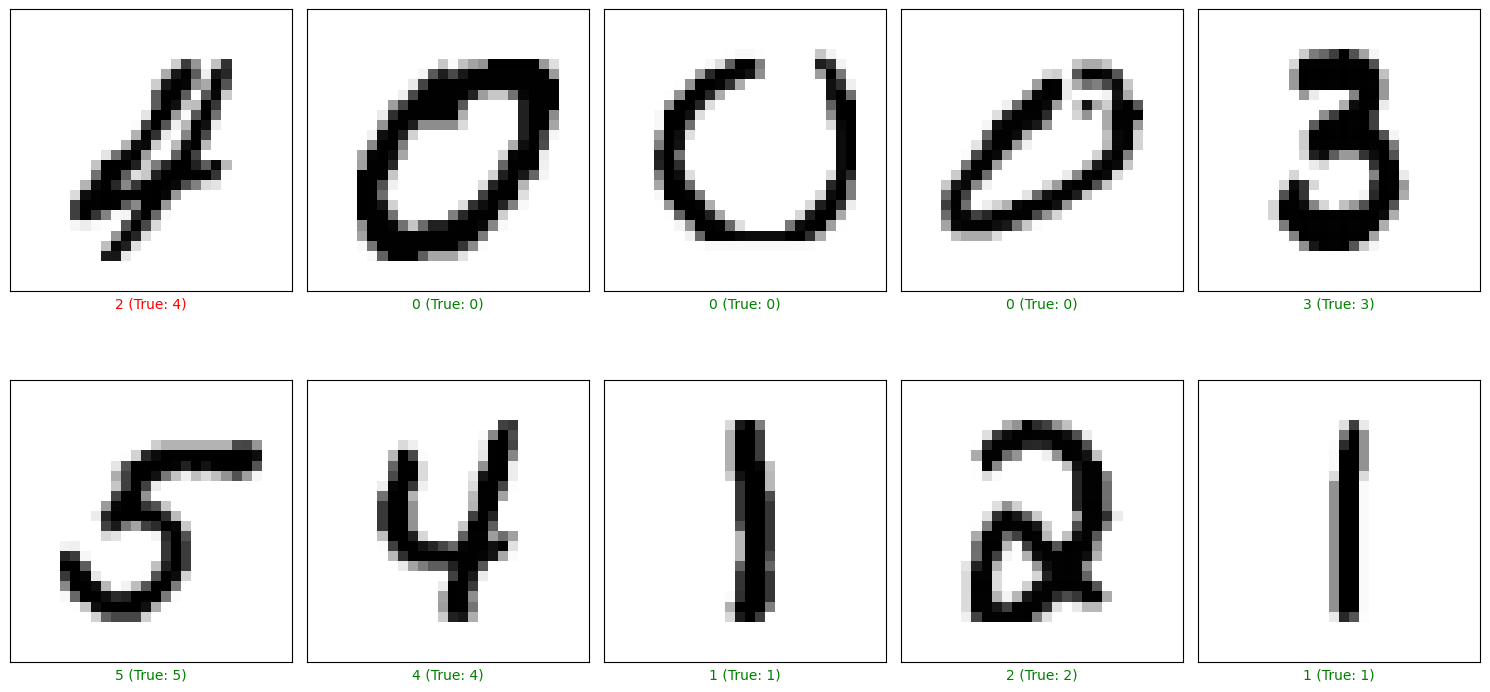

In [133]:
# 32 batch_size
batch_size = 32
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

In [ ]:
# 128 batch_size
batch_size = 128
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

In [ ]:
# 256 batch_size
batch_size = 256
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

optimizer = optim.SGD(model.parameters(), lr=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

## 3. Adding L2 Regularization
### Experiment
- Incorporate L2 regularization by setting a **`weight_decay` parameter** in the optimizer.
- Test with different `weight_decay` values, such as:
  - **0.0**: No regularization is default.
  - **0.0001**: Very light regularization.
  - **0.001**: Light regularization.
  - **0.01**: Moderate regularization.
  - **0.1**: Strong regularization.

### Expected Observations
- **No Regularization**: Model might overfit to the training data.
- **Light Regularization**: Balances model complexity and generalization.
- **Strong Regularization**: Might underfit the data, leading to poor training accuracy.

---

Epoch 1/100, Train Loss: 0.2313, Train Accuracy: 93.73%, Val Loss: 0.2787, Val Accuracy: 92.33%
Epoch 2/100, Train Loss: 0.2313, Train Accuracy: 93.71%, Val Loss: 0.2789, Val Accuracy: 92.35%
Epoch 3/100, Train Loss: 0.2313, Train Accuracy: 93.71%, Val Loss: 0.2786, Val Accuracy: 92.37%
Epoch 4/100, Train Loss: 0.2312, Train Accuracy: 93.68%, Val Loss: 0.2787, Val Accuracy: 92.36%
Epoch 5/100, Train Loss: 0.2313, Train Accuracy: 93.67%, Val Loss: 0.2787, Val Accuracy: 92.39%
Epoch 6/100, Train Loss: 0.2313, Train Accuracy: 93.70%, Val Loss: 0.2785, Val Accuracy: 92.40%
Epoch 7/100, Train Loss: 0.2313, Train Accuracy: 93.69%, Val Loss: 0.2785, Val Accuracy: 92.38%
Epoch 8/100, Train Loss: 0.2313, Train Accuracy: 93.72%, Val Loss: 0.2784, Val Accuracy: 92.36%
Epoch 9/100, Train Loss: 0.2313, Train Accuracy: 93.68%, Val Loss: 0.2784, Val Accuracy: 92.37%
Epoch 10/100, Train Loss: 0.2313, Train Accuracy: 93.73%, Val Loss: 0.2787, Val Accuracy: 92.41%
Epoch 11/100, Train Loss: 0.2313, Train

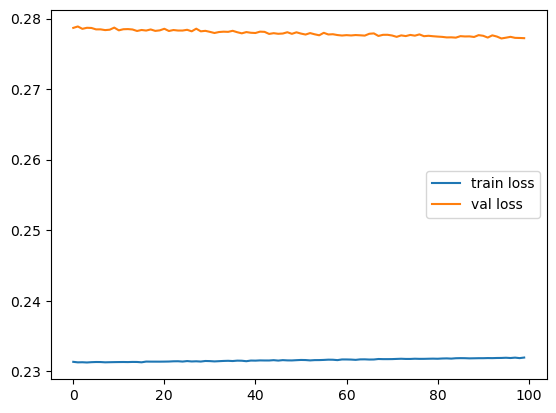

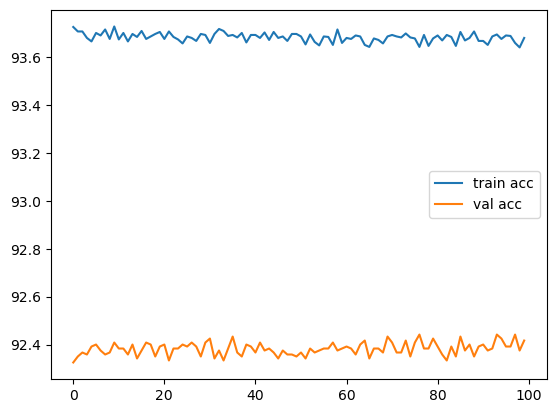

Test Loss: 0.2673, Test Accuracy: 0.9253


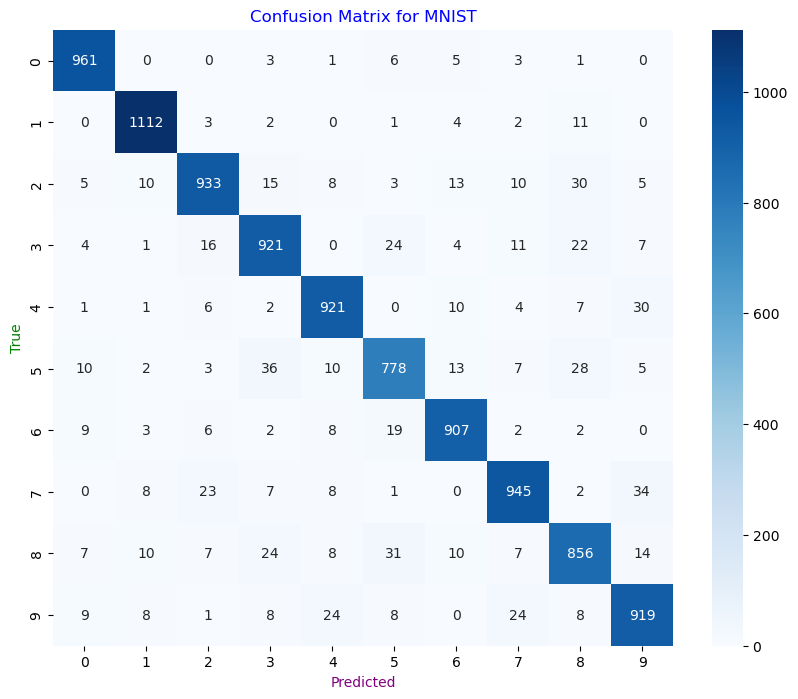

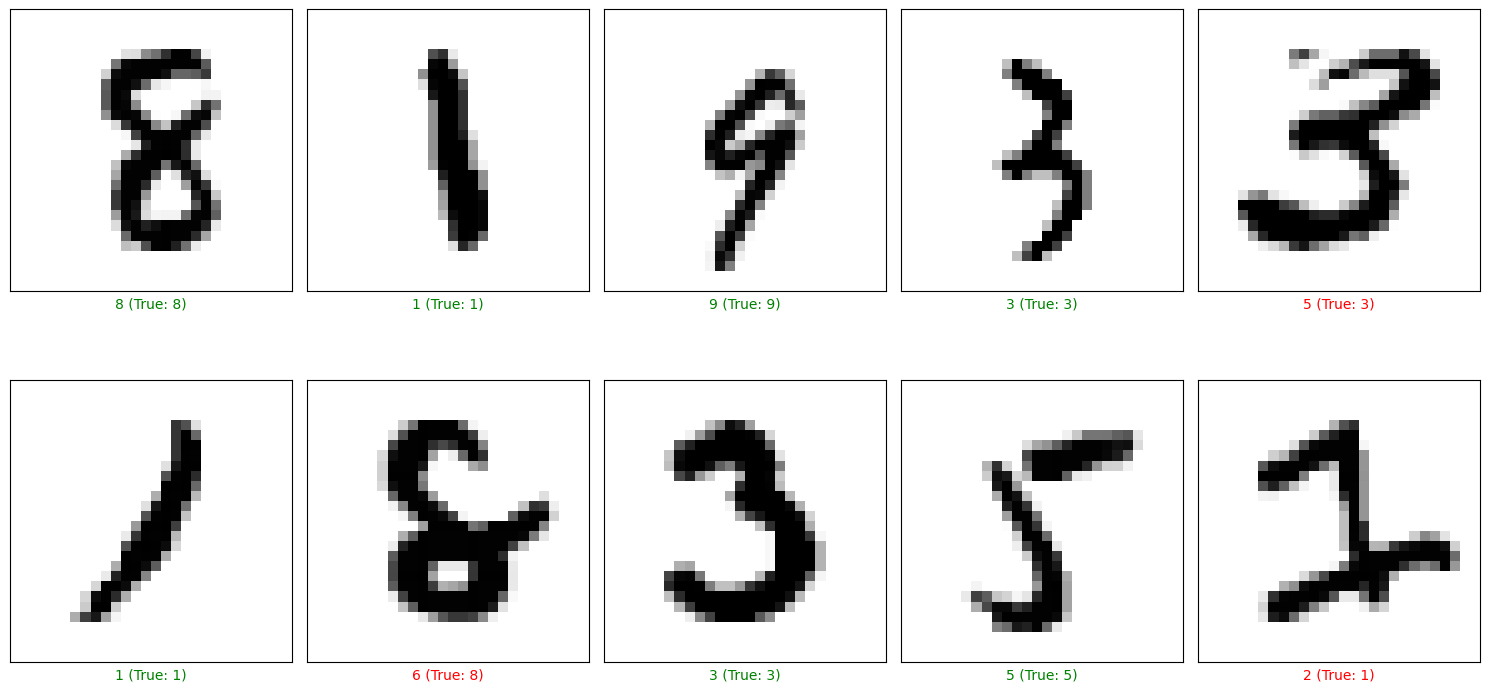

In [101]:
# 0.0001 regulariztion
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

Epoch 1/50, Train Loss: 0.2387, Train Accuracy: 93.50%, Val Loss: 0.2770, Val Accuracy: 92.40%
Epoch 2/50, Train Loss: 0.2389, Train Accuracy: 93.43%, Val Loss: 0.2767, Val Accuracy: 92.42%
Epoch 3/50, Train Loss: 0.2391, Train Accuracy: 93.48%, Val Loss: 0.2766, Val Accuracy: 92.40%
Epoch 4/50, Train Loss: 0.2393, Train Accuracy: 93.48%, Val Loss: 0.2767, Val Accuracy: 92.39%
Epoch 5/50, Train Loss: 0.2396, Train Accuracy: 93.48%, Val Loss: 0.2764, Val Accuracy: 92.43%
Epoch 6/50, Train Loss: 0.2398, Train Accuracy: 93.50%, Val Loss: 0.2767, Val Accuracy: 92.43%
Epoch 7/50, Train Loss: 0.2400, Train Accuracy: 93.47%, Val Loss: 0.2765, Val Accuracy: 92.44%
Epoch 8/50, Train Loss: 0.2403, Train Accuracy: 93.46%, Val Loss: 0.2764, Val Accuracy: 92.44%
Epoch 9/50, Train Loss: 0.2405, Train Accuracy: 93.46%, Val Loss: 0.2765, Val Accuracy: 92.42%
Epoch 10/50, Train Loss: 0.2408, Train Accuracy: 93.47%, Val Loss: 0.2767, Val Accuracy: 92.33%
Epoch 11/50, Train Loss: 0.2411, Train Accuracy: 

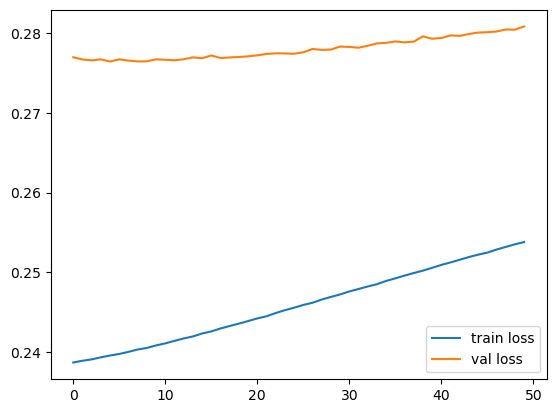

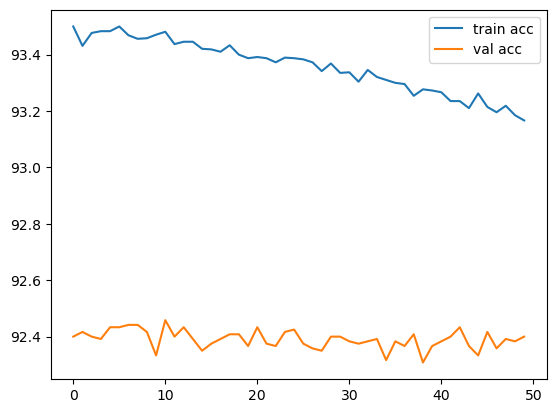

Test Loss: 0.2696, Test Accuracy: 0.9243


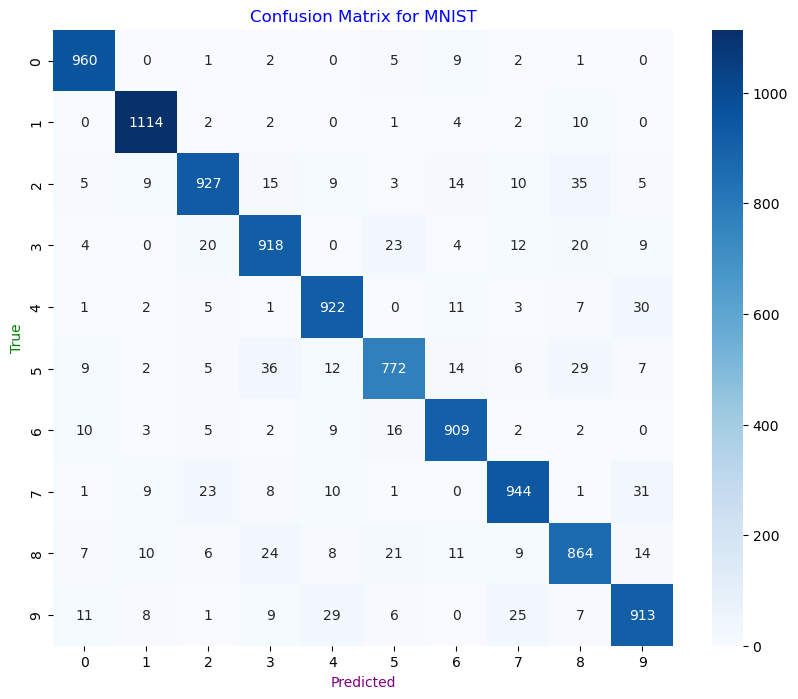

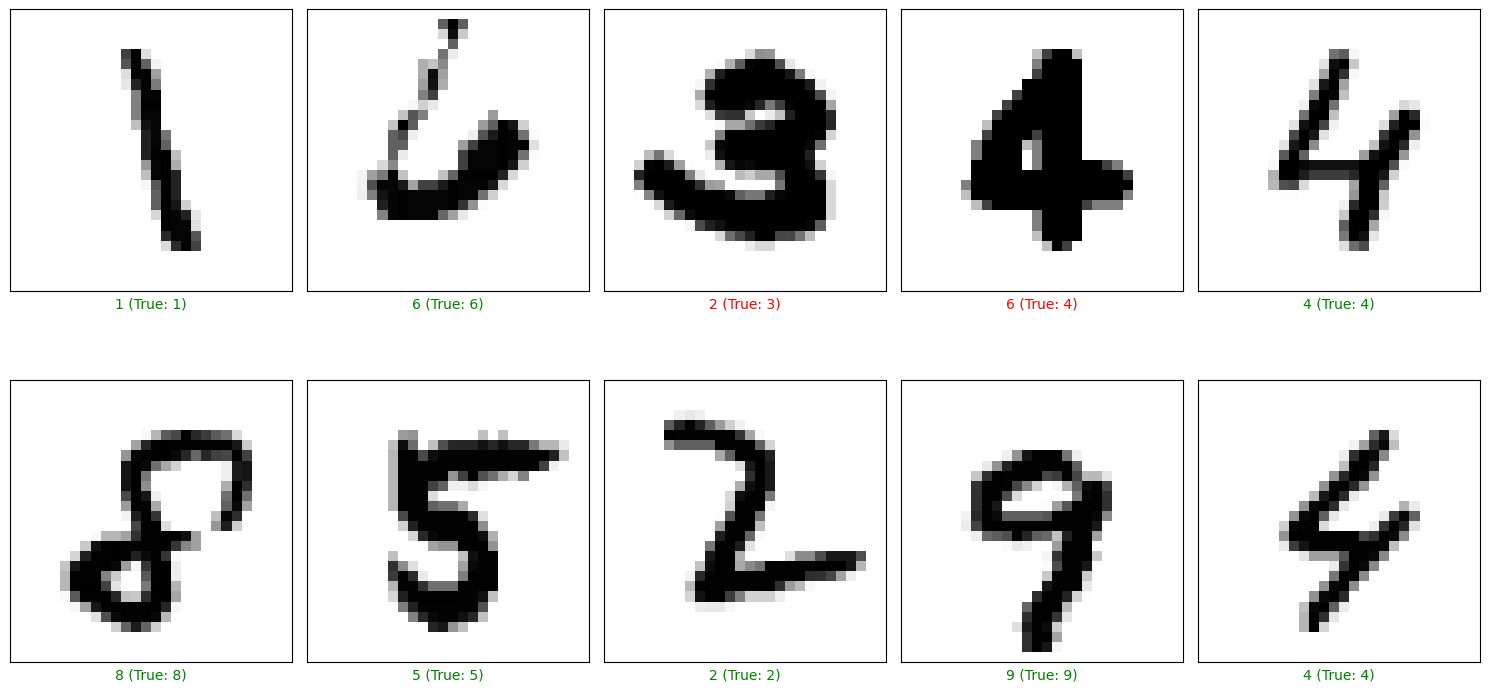

In [134]:
# 0.001 regulariztion
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

Epoch 1/50, Train Loss: 0.4054, Train Accuracy: 90.12%, Val Loss: 0.4056, Val Accuracy: 90.15%
Epoch 2/50, Train Loss: 0.4055, Train Accuracy: 90.08%, Val Loss: 0.4055, Val Accuracy: 90.20%
Epoch 3/50, Train Loss: 0.4056, Train Accuracy: 90.10%, Val Loss: 0.4056, Val Accuracy: 90.21%
Epoch 4/50, Train Loss: 0.4057, Train Accuracy: 90.10%, Val Loss: 0.4057, Val Accuracy: 90.17%
Epoch 5/50, Train Loss: 0.4057, Train Accuracy: 90.08%, Val Loss: 0.4060, Val Accuracy: 90.17%
Epoch 6/50, Train Loss: 0.4058, Train Accuracy: 90.08%, Val Loss: 0.4060, Val Accuracy: 90.19%
Epoch 7/50, Train Loss: 0.4059, Train Accuracy: 90.12%, Val Loss: 0.4058, Val Accuracy: 90.23%
Epoch 8/50, Train Loss: 0.4060, Train Accuracy: 90.10%, Val Loss: 0.4056, Val Accuracy: 90.17%
Epoch 9/50, Train Loss: 0.4061, Train Accuracy: 90.06%, Val Loss: 0.4058, Val Accuracy: 90.17%
Epoch 10/50, Train Loss: 0.4061, Train Accuracy: 90.09%, Val Loss: 0.4061, Val Accuracy: 90.23%
Epoch 11/50, Train Loss: 0.4061, Train Accuracy: 

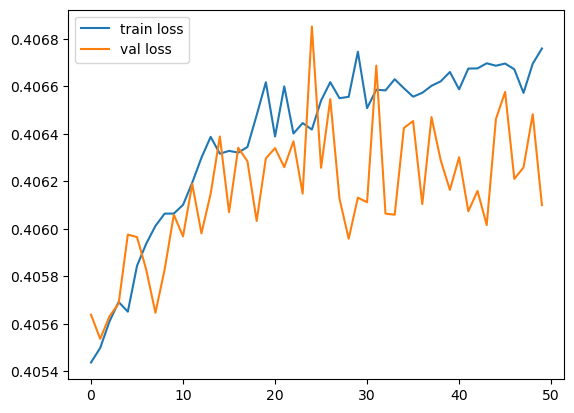

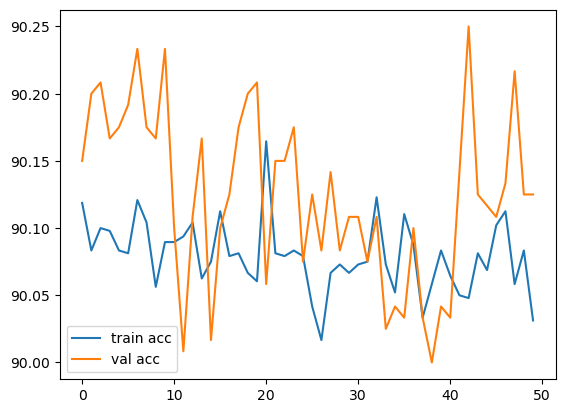

Test Loss: 0.3884, Test Accuracy: 0.9074


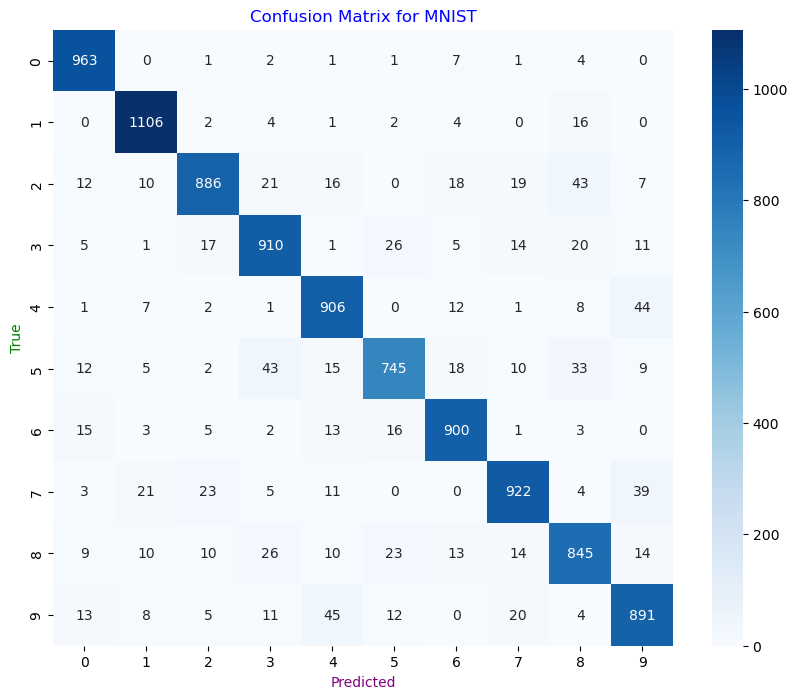

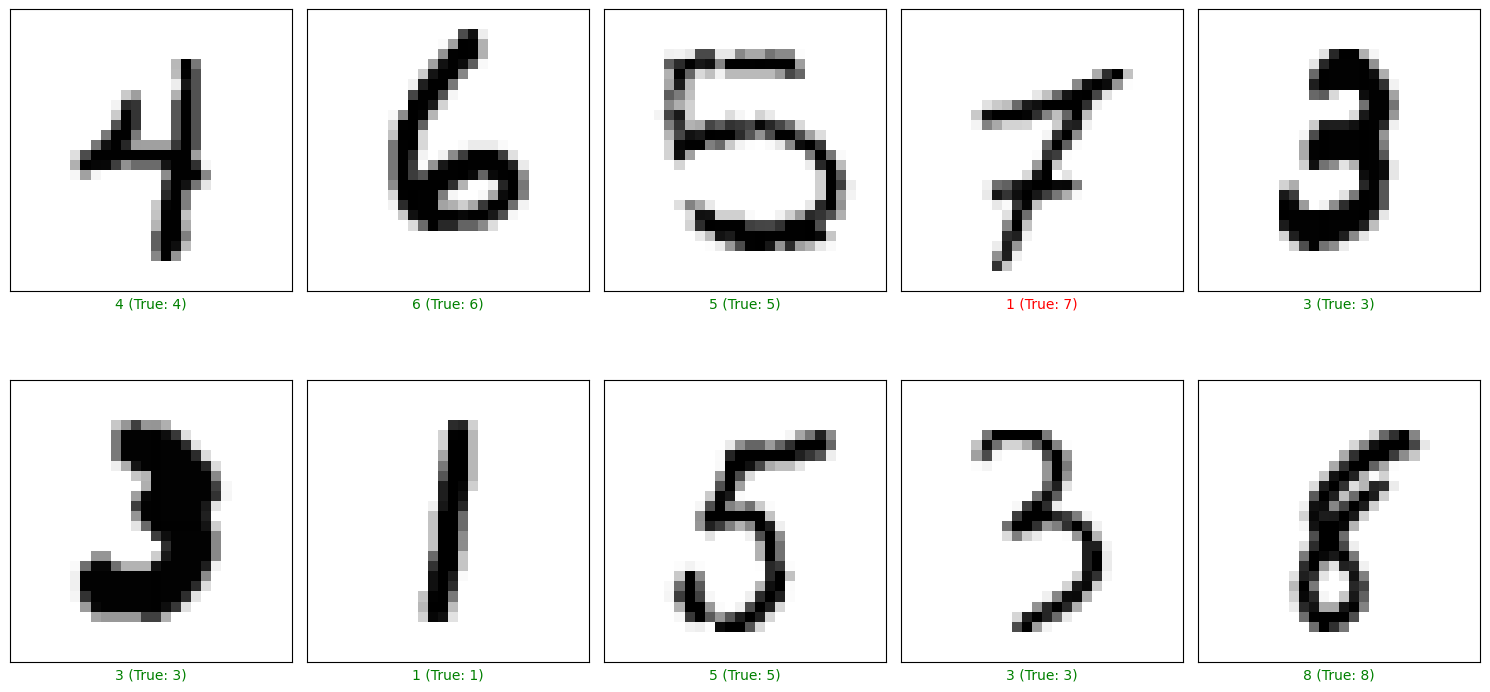

In [136]:
# 0.01 regulariztion
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

In [ ]:
# 0.1 regulariztion
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1) # lr: learning rate

train_losses, val_losses, train_accuracies, val_accuracies = train_model(optimizer, model, train_loader, val_loader, epochs=50)
history = {"loss": train_losses, "val_loss": val_losses, "accuracy" : train_accuracies, "val_accuracy": val_accuracies}
acc_loss_plots(history)

test_pred, x_test, y_test = evaluate_model()
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(test_pred, y_test, class_names,title="Confusion Matrix for MNIST", color="Blues")
visualize_predictions(test_pred, x_test, y_test, class_names, num_images=10, rows=4, cols=5)

# Bonus: Feedforward Neural Network

### Data Loading

In [102]:
# importing the built in mnist dataset from kersas
(X_train_full,y_train_full),(X_test,y_test)=keras.datasets.mnist.load_data()
# combine training and testing data
X_combined = np.concatenate([X_train_full,X_test],axis=0)
y_combined = np.concatenate([y_train_full,y_test],axis=0)

### Data Preparation

In [103]:
# normalize pixel from [0,255] values to [0, 1]
X_combined = X_combined / 255.0


In [104]:
# reshape data to suit the fully connected layer in neural network input into a 1d array of size 28*28
X_combined = X_combined.reshape(-1,28*28)

In [105]:
# split dataset into training, validation, and testing sets (60/20/20 split)
X_train, X_remaining, y_train, y_remaining = train_test_split(X_combined,y_combined,test_size=0.4,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining,y_remaining,test_size=0.5,random_state=42)

## From scratch

In [106]:
class FNN_FROM_SCRATCH:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.layers = []
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        prev_size = input_size
        
        # initialize weights and biases for each layer
        for hidden_size in hidden_sizes:
            W = np.random.rand(hidden_size, prev_size) - 0.5
            b = np.random.rand(hidden_size, 1) - 0.5
            self.layers.append((W, b))
            prev_size = hidden_size
        
        # output layer
        W_out = np.random.rand(output_size, prev_size) - 0.5
        b_out = np.random.rand(output_size, 1) - 0.5
        self.layers.append((W_out, b_out))

    # relu function formula is f(x) = max(0,x)
    def ReLU(self, Z):
        return np.maximum(0, Z)
        
    # relu derivative in back propagation
    def ReLU_deriv(self, Z):
        return (Z > 0).astype(float)
    
    # softmax --> convert score to probabilities
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

    # forward propagation
    def forward_prop(self, X):
        activations = [X]
        Zs = []
        
        # forward pass through all layers
        for i, (W, b) in enumerate(self.layers[:-1]):
            Z = np.dot(W, activations[-1]) + b
            A = self.ReLU(Z)
            activations.append(A)
            Zs.append(Z)
        
        # output layer
        W_out, b_out = self.layers[-1]
        Z_out = np.dot(W_out, activations[-1]) + b_out
        A_out = self.softmax(Z_out)
        activations.append(A_out)
        Zs.append(Z_out)
        
        return activations, Zs

    # one hot encoding
    def one_hot(self, Y, num_classes=10):
        # Y is expected to be 1D (class labels), so we convert to one-hot encoded 2D array
        one_hot_Y = np.zeros((num_classes, Y.size))
        one_hot_Y[Y, np.arange(Y.size)] = 1
        return one_hot_Y

    # backward propagation
    def backward_prop(self, activations, Zs, X, Y):
        m = X.shape[1]
        one_hot_Y = self.one_hot(Y)
        
        # backpropagation through output layer
        dA = activations[-1] - one_hot_Y
        dW = np.dot(dA, activations[-2].T) / m
        db = np.sum(dA, axis=1, keepdims=True) / m
        grads = [(dW, db)]
        
        # backpropagation through hidden layers
        for i in range(len(self.layers) - 2, -1, -1):
            dZ = np.dot(self.layers[i + 1][0].T, dA) * self.ReLU_deriv(Zs[i])
            dW = np.dot(dZ, activations[i].T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            grads.insert(0, (dW, db))
            dA = dZ  # for the next iteration
        
        return grads

    # update parameters using gradient descent
    def update_params(self, grads, alpha):
        for i in range(len(self.layers)):
            dW, db = grads[i]
            self.layers[i] = (self.layers[i][0] - alpha * dW, self.layers[i][1] - alpha * db)
        return self.layers

    # model predictions
    def get_predictions(self, A2):
        return np.argmax(A2, axis=0)

    # compute accuracy
    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size

    # gradient descent
    def gradient_descent(self, X, Y, alpha, iterations, X_val, y_val):
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
        # Convert Y to one-hot encoding
        Y_one_hot = self.one_hot(Y)
        y_val_one_hot = self.one_hot(y_val)
    
        for i in range(iterations):
            # forward propagation for training data
            activations, Zs = self.forward_prop(X)
            grads = self.backward_prop(activations, Zs, X, Y)
            self.update_params(grads, alpha)
    
            # calculate training loss and accuracy
            train_predictions = self.get_predictions(activations[-1])
            train_accuracy = self.get_accuracy(train_predictions, Y)
            train_loss = self.loss_function(activations[-1], Y_one_hot)
    
            # track history
            history['loss'].append(train_loss)
            history['accuracy'].append(train_accuracy)
    
            # forward propagation for validation data
            activations_val, _ = self.forward_prop(X_val)
            val_predictions = self.get_predictions(activations_val[-1])
            val_accuracy = self.get_accuracy(val_predictions, y_val)
            val_loss = self.loss_function(activations_val[-1], y_val_one_hot)
    
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)
    
            if i % 10 == 0:
                print(f"Iteration {i} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f}")
                print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")
    
        return history

    # loss function (cross-entropy loss)
    def loss_function(self, predictions, Y):
        # compute cross-entropy loss 
        m = Y.shape[1]
        log_probs = -np.log(predictions + 1e-10)
        loss = np.sum(np.multiply(log_probs, Y)) / m
        return loss


In [107]:
# hyper parameters
input_size = 784  # 28x28 images flattened
hidden_sizes = [128,64]  
output_size = 10 
learning_rate = 0.1 
iterations = 100

# init the model
model = FNN_FROM_SCRATCH(input_size, hidden_sizes, output_size)

# train the model using gradient descent
history = model.gradient_descent(X_train.T, y_train, learning_rate, iterations, X_val.T, y_val)

# make predictions on the test set
activations, _ = model.forward_prop(X_test.T)
y_pred = model.get_predictions(activations[-1])

# evaluate the model
accuracy = model.get_accuracy(y_pred, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))


Iteration 0 - Loss: 14.4929 - Accuracy: 0.0752
Validation Loss: 11.2763 - Validation Accuracy: 0.1479
Iteration 10 - Loss: 1.6438 - Accuracy: 0.5378
Validation Loss: 1.5975 - Validation Accuracy: 0.5525
Iteration 20 - Loss: 1.1455 - Accuracy: 0.6606
Validation Loss: 1.1594 - Validation Accuracy: 0.6587
Iteration 30 - Loss: 0.9396 - Accuracy: 0.7169
Validation Loss: 0.9681 - Validation Accuracy: 0.7071
Iteration 40 - Loss: 0.8212 - Accuracy: 0.7500
Validation Loss: 0.8552 - Validation Accuracy: 0.7401
Iteration 50 - Loss: 0.7413 - Accuracy: 0.7749
Validation Loss: 0.7777 - Validation Accuracy: 0.7629
Iteration 60 - Loss: 0.6822 - Accuracy: 0.7928
Validation Loss: 0.7201 - Validation Accuracy: 0.7806
Iteration 70 - Loss: 0.6363 - Accuracy: 0.8070
Validation Loss: 0.6753 - Validation Accuracy: 0.7930
Iteration 80 - Loss: 0.5992 - Accuracy: 0.8181
Validation Loss: 0.6390 - Validation Accuracy: 0.8033
Iteration 90 - Loss: 0.5685 - Accuracy: 0.8280
Validation Loss: 0.6087 - Validation Accura

### Analysis 

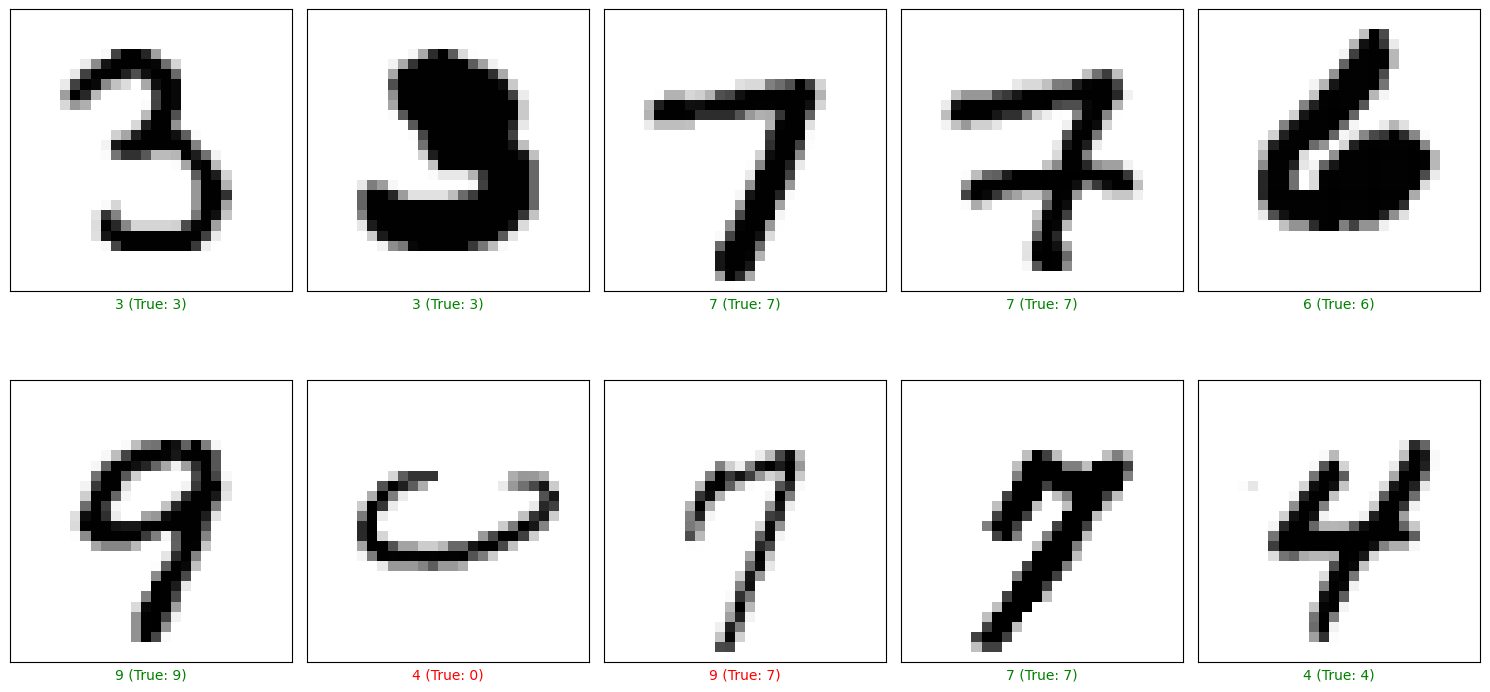

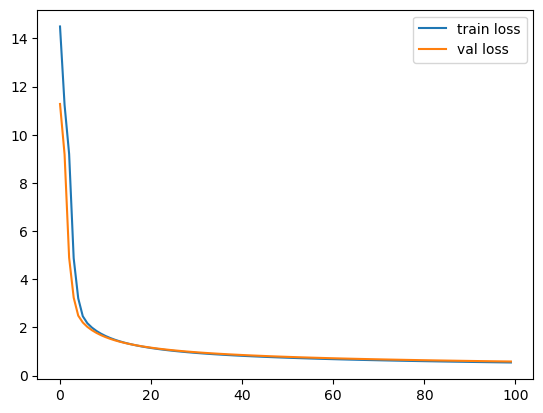

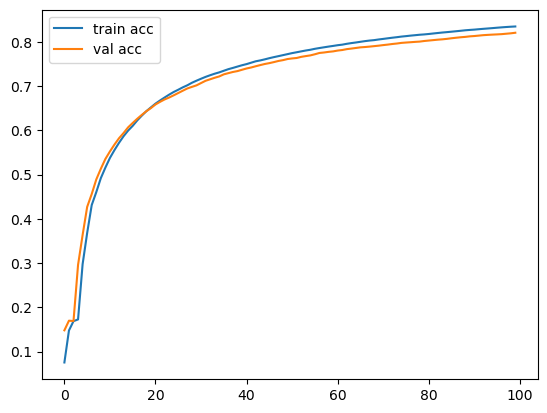

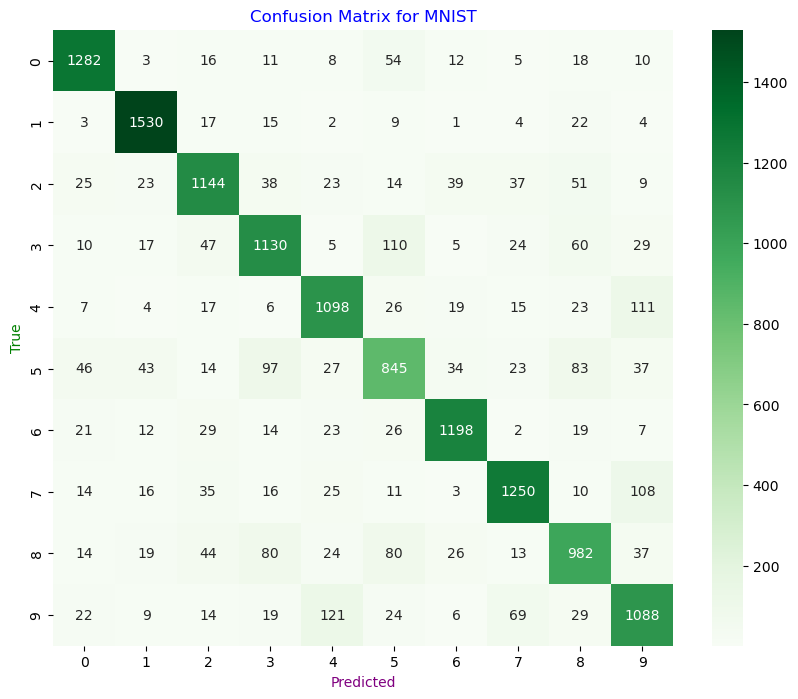

In [108]:
# visualization 
classes_names = [str(i) for i in range(10)]
visualize_predictions(y_pred, X_test, y_test, classes_names)  
acc_loss_plots(history)
plot_confusion_matrix(y_pred, y_test, classes_names, title="Confusion Matrix for MNIST", color="Greens")

## Using Tensorflow keras

### Model architecture

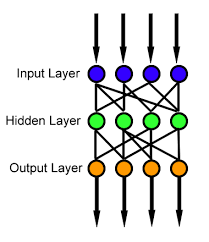
* Input layer: accepts flattened 28x28=784 features
* Hidden layer 1:
    - fully connected dense layer with 256 neurons.
    - relu activation
    - batch normalization
    - dropout 40% for regularization
* Hidden layer 2:
    - fully connected dense layer with 128 neurons.
    - relu activation
    - batch normalization
    - dropout 40% for regularization
* Hidden Layer 3:
    - fully connected dense layer with 64 neurons.
    - relu activation
    - batch normalization
    - dropout 30% for regularization
* Hidden Layer 4:
    - fully connected dense layer with 32 neurons.
    - relu activation
    - batch normalization
    - dropout 20% for regularization
* Output Layer:
    - fully connected dense layer with 10 neurons for the ten classes numbers 0-9
    - activation softmax for multi-class classification.

#### Why we used batch normalization?

Batch Normalization Concept

instead of just normalizing the input only and fed it into the network. We normalize the output of all the layers of the network.

It helps the network overcome the unstable gradients. As neural networks train, the outputs of neurons in each layer can shift due to updates in the weights.this occurs because the inputs to each layer depend on the outputs of the previous layers and as the parameters in earlier layers change so do the inputs to later layers. This shift slows down training because the layers constantly need to adjust to the new distributions. It often leads to issues like vanishing gradients or exploding gradients in deep networks making it hard for the network to learn effectively.

Batch normalization helps by reducing the amount of change in the distribution of layer inputs during training making the training process more stable and allowing higher learning rates.
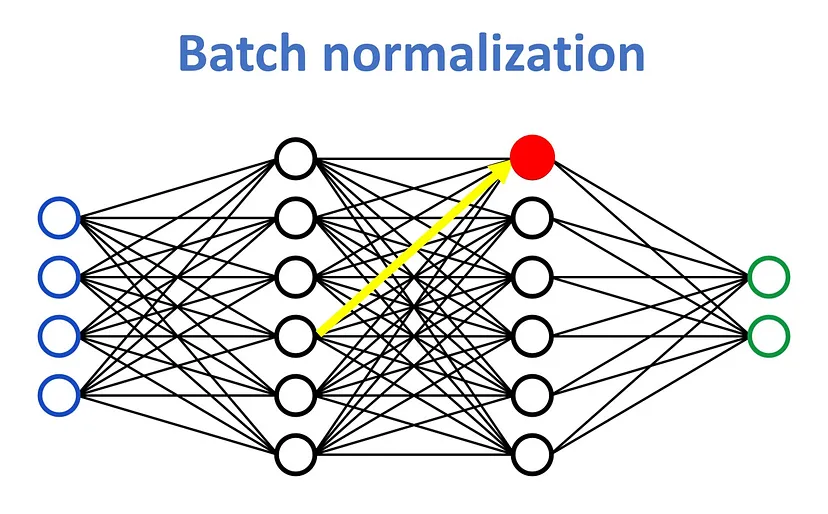

In [109]:
def build_model():
    """
    builds feedforward neural network for MNIST classification.
    returns a compiled keras model
    """
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(28*28,)),  # input layer for flattened images
        keras.layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(), 
        keras.layers.Dropout(0.4), 

        keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),

        keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(10, activation='softmax')  # output layer with 10 classes 0-9
    ])

    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),  
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

### Configurations

In [110]:
EPOCHS = 50
BATCH_SIZE = 64

# early stopping callback to prevent overfitting
es = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  
    patience=20,  # stop after 20 epochs of no improvement
    verbose=1,
    mode="max",
    restore_best_weights=True  # restore the weights of the best epoch
)

# adjust learning rate when progress stops
rp = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", 
    factor=0.2,  # reduce learning rate by a factor of 5
    patience=3,  # wait for 3 epochs before reducing
    verbose=1,
    mode="max",
    min_lr=1e-5  # minimum learning rate
)

### Model training

In [111]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               200960    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [112]:
# train the model and store the results(accuracy,loss) in history object
start_time = time.time()
history_FNN = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es,rp], 
    verbose=2
)
training_time = time.time() - start_time

Epoch 1/50
657/657 - 6s - loss: 1.2457 - accuracy: 0.7795 - val_loss: 0.6591 - val_accuracy: 0.9347 - lr: 0.0010 - 6s/epoch - 9ms/step
Epoch 2/50
657/657 - 4s - loss: 0.7269 - accuracy: 0.9047 - val_loss: 0.5018 - val_accuracy: 0.9545 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 3/50
657/657 - 3s - loss: 0.5778 - accuracy: 0.9254 - val_loss: 0.4273 - val_accuracy: 0.9552 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 4/50
657/657 - 3s - loss: 0.5046 - accuracy: 0.9309 - val_loss: 0.3707 - val_accuracy: 0.9604 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 5/50
657/657 - 3s - loss: 0.4568 - accuracy: 0.9340 - val_loss: 0.3460 - val_accuracy: 0.9620 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 6/50
657/657 - 4s - loss: 0.4300 - accuracy: 0.9374 - val_loss: 0.3440 - val_accuracy: 0.9585 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 7/50
657/657 - 4s - loss: 0.4142 - accuracy: 0.9375 - val_loss: 0.3095 - val_accuracy: 0.9655 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 8/50
657/657 - 4s - loss: 0.3909 - accuracy: 0.94

### Analysis

In [113]:
print(f'The training time using feedforward neural network {training_time} sec')

The training time using feedforward neural network 178.57389783859253 sec


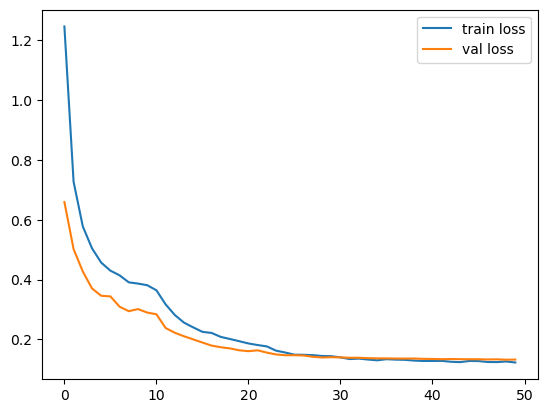

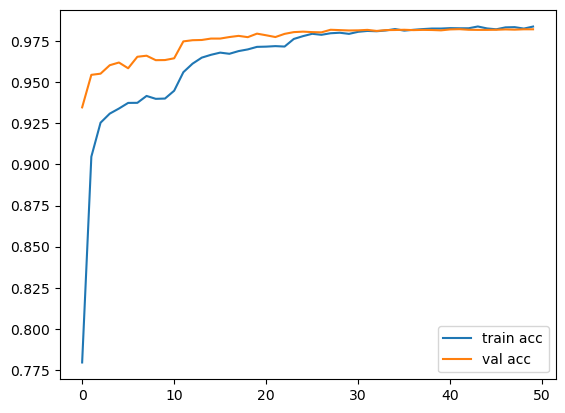

In [114]:
acc_loss_plots(history_FNN.history)

In [115]:
# evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy}")

438/438 - 1s - loss: 0.1389 - accuracy: 0.9796 - 649ms/epoch - 1ms/step
Test Accuracy: 0.9796428680419922


In [116]:
# make predictions using test set
predictions = model.predict(X_test)

438/438 [==============================] - 1s 1ms/step


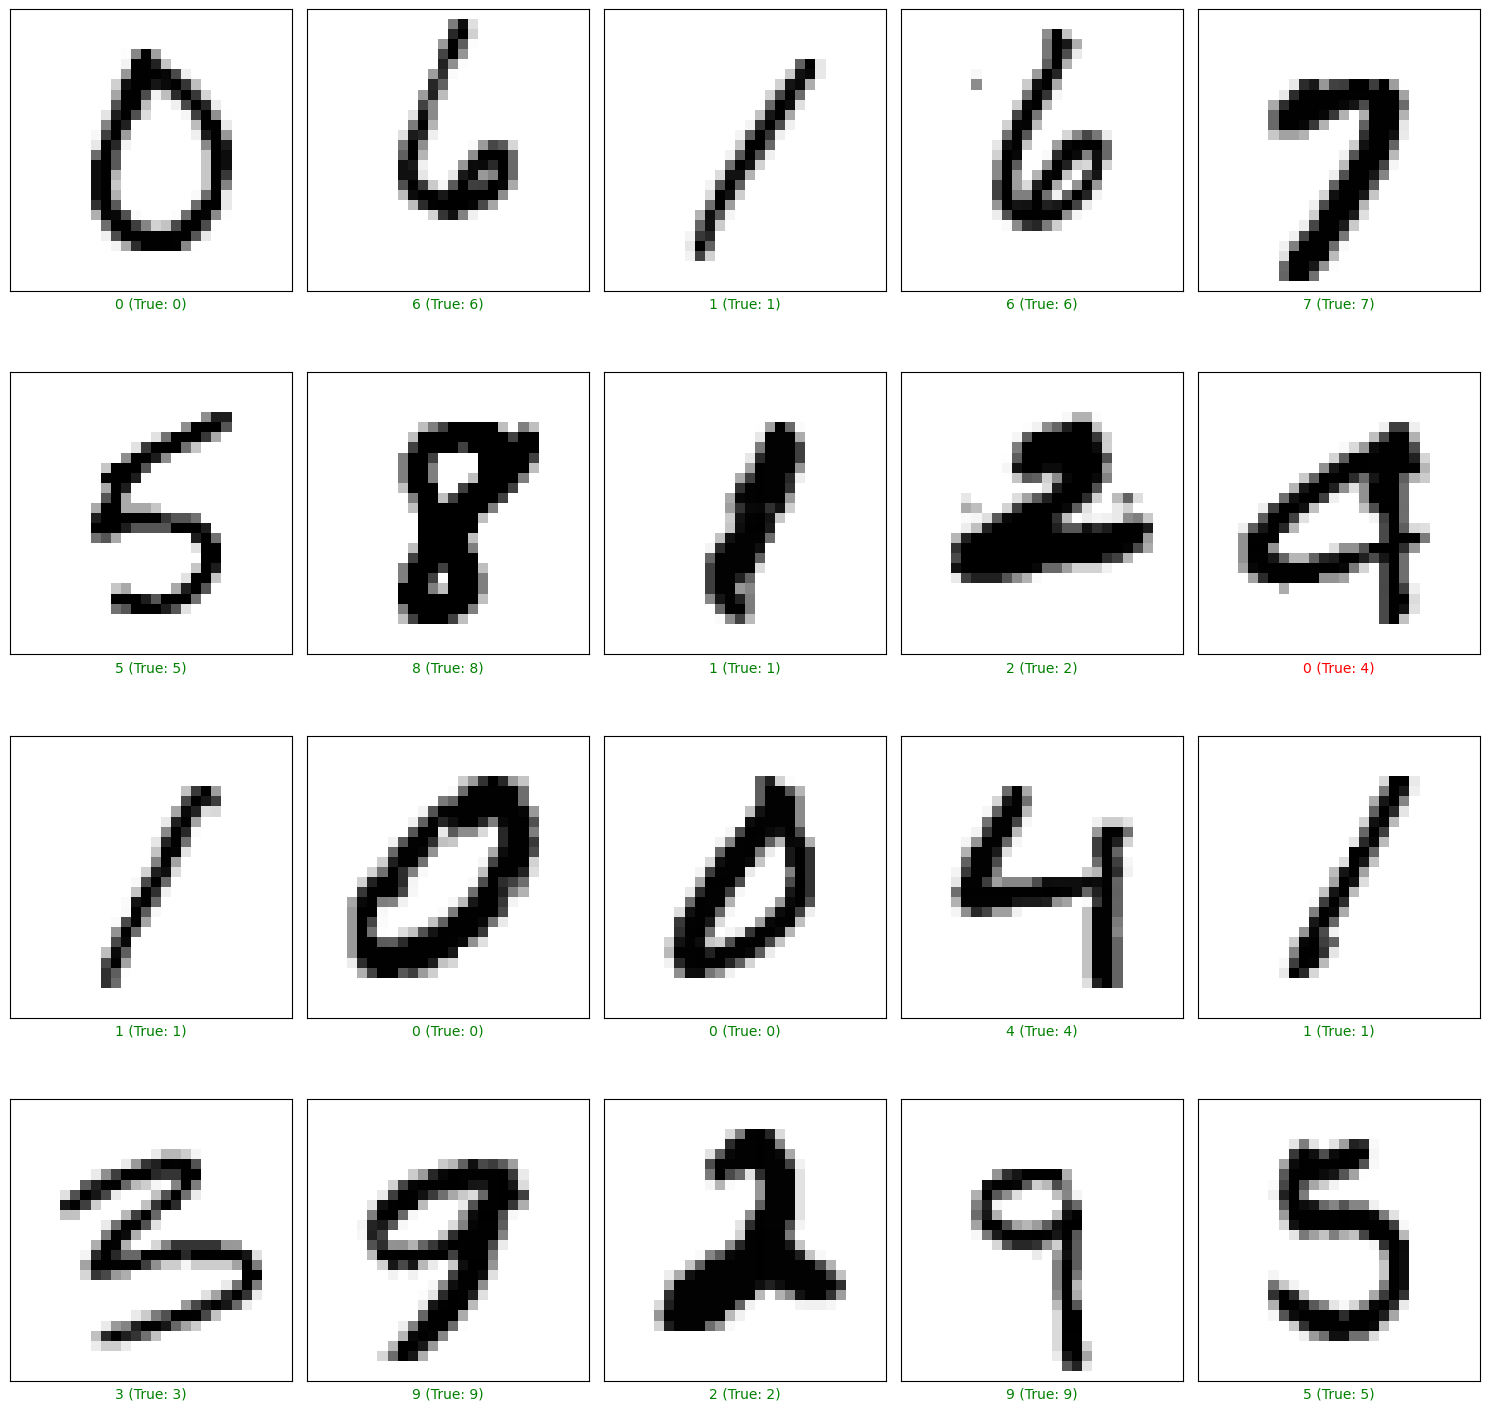

In [117]:
# visualize some predictions
classes_names = [str(i) for i in range(10)]
visualize_predictions(predictions, X_test, y_test, classes_names, 20,4,5)

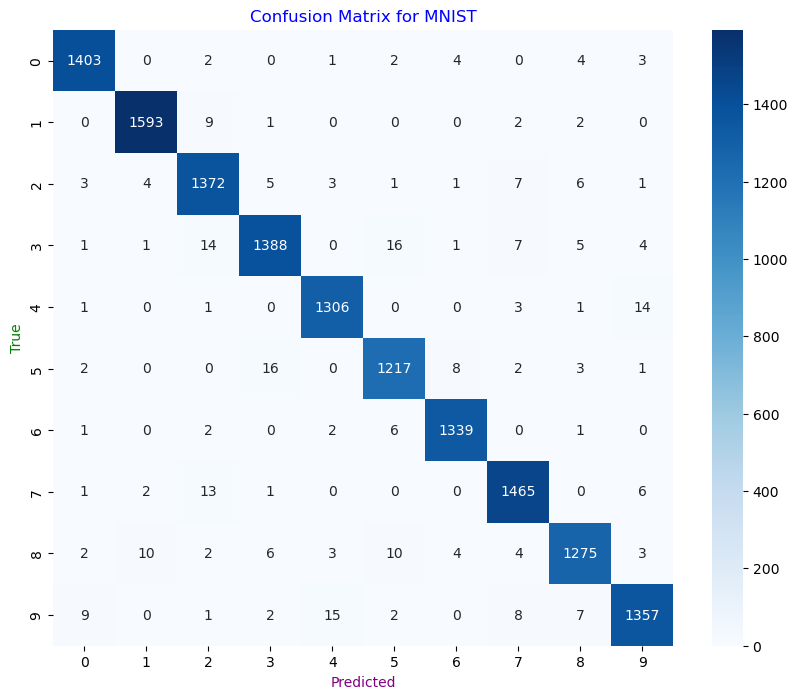

In [118]:
plot_confusion_matrix(predictions, y_test, classes_names, title="Confusion Matrix for MNIST", color="Blues")